In [1719]:
import cx_Oracle as ora
import numpy as np
import pandas as pd

# bibliotecas graficas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Gráfico QQ-Plot
import scipy.stats as stats

# bibliotecas IA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [1720]:
conn = ora.connect("system", "manager", "localhost/XE")
cursor = conn.cursor()


In [1721]:
# aumentar a area de saida para imprimir o data frame
desired_width = 320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 300)

In [1722]:
#-- PRODUTOS PARA TESTAR
# PART-NUMBER	PERIODO		Nr TRANS	DESCRICAO
#======================================================================
# FAT13M1S1		2006-2018	42887		PALMSECURE DIGITALIZADOR
# PA03540-0001	2008-2022	2998		CONSUMABLE, BRAKE ROLLER
# PA03670-B051	2014-2022	1973		Scanner Model  fi-7160S
# PA03338-K011	2004-2022	2642		CONSUMABLES, PICK ROLLER SET
# PA03641-B301	2016-2022	568			Scanner Model ScanSnap SV600


In [1723]:
    sql = """
            SELECT ME.U##COD_ESTABEL,
                   REPLACE(IT.IT_CODIGO,CHR(34),'') IT_CODIGO,
                   REPLACE(REPLACE(IT.DESC_ITEM,CHR(10),''),CHR(13),'') DESC_ITEM,
                   DECODE(ME.TIPO_TRANS,1,'ENT','SAI') TP_TRANS,
                   ME.DT_TRANS,
                   TO_CHAR(ME.DT_TRANS,'YYYY') ANO,
                   TO_CHAR(ME.DT_TRANS,'MM')   MES,
                   ME.U##NRO_DOCTO,
                   ME.U##SERIE_DOCTO,
                   ME.COD_EMITENTE,
                   EMIT.NOME_EMIT,
                   ME.U##NAT_OPERACAO,
                   REPLACE(REPLACE(NATOP.DENOMINACAO,CHR(10),''),CHR(13),'') DENOMINACAO,
                   ME.SEQUEN_NF,
            --       ME.DESCRICAO_DB,
                   ME.U##COD_LOCALIZ,
                   DECODE(NVL(ME.ESP_DOCTO,0),
                            1,'ACA',
                            2,'ACT',
                            5,'REQ',
                            6,'DIV',
                            8,'EAC',
                            16,'IPL',
                            18,'NC',
                            20,'NFD',
                            21,'NFE',
                            22,'NFS',
                            23,'NFT',
                            25,'REF',
                            28,'DEV',
                            32,'STR',
                            33,'TRA',
                            35,'SOB',
                            ME.ESP_DOCTO) ESP_DOCTO,
                   ME.COD_DEPOS,
                   ME.QUANTIDADE,
                   ROUND(ITNF.VL_PREUNI,2) VL_VENDA_UNIT,
                   ROUND((NVL(ME.QUANTIDADE,0) * ITNF.VL_PREUNI),2) VL_VENDA_TOT,
                   ROUND(ME.VALOR_MAT_M##1 / (DECODE(NVL(ME.QUANTIDADE,0),0,1,ME.QUANTIDADE)),2) VL_MATERIAL_UNIT,
                   ME.VALOR_MAT_M##1 VL_MATERIAL_TOT,
                   CMV.CMV_UNITARIO,
                   ROUND((NVL(ME.QUANTIDADE,0) * NVL(CMV.CMV_UNITARIO,0)),2) CMV_TOTAL,
                   CASE 
                       WHEN ME.ESP_DOCTO=22 AND ITNF.VL_PREUNI >= (ROUND(ME.VALOR_MAT_M##1 / (DECODE(NVL(ME.QUANTIDADE,0),0,1,ME.QUANTIDADE)),2)) THEN
                         ROUND((((NVL(ME.QUANTIDADE,0) * ITNF.VL_PREUNI) - ME.VALOR_MAT_M##1) / (NVL(ME.QUANTIDADE,0) * ITNF.VL_PREUNI)) * 100,1)
                       WHEN ME.ESP_DOCTO=22 AND ITNF.VL_PREUNI < (ROUND(ME.VALOR_MAT_M##1 / (DECODE(NVL(ME.QUANTIDADE,0),0,1,ME.QUANTIDADE)),2)) THEN
                         ROUND((((NVL(ME.QUANTIDADE,0) * ITNF.VL_PREUNI) - ME.VALOR_MAT_M##1) / (NVL(ME.QUANTIDADE,0) * ITNF.VL_PREUNI)) * 100,1)
                       ELSE
                         0
                   END PERC_MARGEM,
                   CMV.SALDO,
                   CMV.CMV_TOT_SALDO,
                   INFL.IPCA
            FROM EMS2_1.ITEM        IT,
                 EMS2_1.MOVTO_ESTOQ ME,
                 EMS2_1.NATUR_OPER  NATOP,
                 (SELECT TO_CHAR(PERIODO,'YYYY/MM') ANO_MES,
                         U##IT_CODIGO,
                         SUM(NVL(QUANTIDADE,0)) SALDO,ROUND(SUM(DISTINCT NVL(VAL_UNIT_MAT_M##1,0)),4) CMV_UNITARIO,
                         ROUND(SUM(NVL(QUANTIDADE,0) * NVL(VAL_UNIT_MAT_M##1,0)),4) CMV_TOT_SALDO
                  FROM EMS2_1.SL_IT_PER
                  GROUP BY TO_CHAR(PERIODO,'YYYY/MM'),U##IT_CODIGO
                  ORDER BY 1) CMV,
                 (SELECT U##COD_ESTABEL,U##SERIE,U##NR_NOTA_FIS,NR_SEQ_FAT,U##IT_CODIGO,VL_PREUNI
                  FROM EMS2_1.IT_NOTA_FISC) ITNF,
                 EMS2MULT.EMITENTE EMIT,
                 EMS2_1.INFLACAO INFL
            WHERE IT.U##IT_CODIGO = ME.U##IT_CODIGO(+)
              AND ME.DT_TRANS BETWEEN :DT_INICIAL AND :DT_FINAL
              AND ME.U##IT_CODIGO                = CMV.U##IT_CODIGO(+)
              AND TO_CHAR(ME.DT_TRANS,'YYYY/MM') = CMV.ANO_MES(+)
              AND ME.U##NAT_OPERACAO             = NATOP.NAT_OPERACAO(+)
              AND ME.U##COD_ESTABEL              = ITNF.U##COD_ESTABEL(+) 
              AND ME.U##SERIE_DOCTO              = ITNF.U##SERIE(+)      
              AND ME.U##NRO_DOCTO                = ITNF.U##NR_NOTA_FIS(+) 
              AND ME.SEQUEN_NF                   = ITNF.NR_SEQ_FAT(+)    
              AND ME.U##IT_CODIGO                = ITNF.U##IT_CODIGO(+)  
              AND ME.COD_EMITENTE                = EMIT.COD_EMITENTE(+)
              AND TO_CHAR(ME.DT_TRANS,'MM')      = INFL.MES(+)
              AND TO_CHAR(ME.DT_TRANS,'YYYY')    = INFL.ANO(+)
              AND IT.U##IT_CODIGO                = :IT_CODIGO
              AND NVL(NATOP.EMITE_DUPLIC,0)      = 1 
             -- AND ME.DT_TRANS                    <= TO_DATE('31-MAY-2022','DD-MON-YYYY')
             -- AND TO_CHAR(ME.DT_TRANS,'YYYY')    = '2008'
             -- AND TO_CHAR(ME.DT_TRANS,'MM')      = '03'
           ORDER BY IT.U##IT_CODIGO,
                    TO_CHAR(ME.DT_TRANS,'YYYY'),
                    TO_CHAR(ME.DT_TRANS,'MM'),
                    ME.U##COD_ESTABEL 
          """


In [1724]:
sIT_CODIGO = 'FAT13M1S1'
df = pd.read_sql(sql=sql, con=conn, params={'IT_CODIGO': sIT_CODIGO,
                                                'DT_INICIAL': '01-JAN-2000',
                                                'DT_FINAL': '31-MAY-2022'})

In [1725]:
# Converte mes para inteiro
df['MES'] = df['MES'].astype('int')

In [1726]:
# filtrar somente os movimentos de saida (faturamento)
df = df[['ANO', 'MES', 'IPCA', 'QUANTIDADE', 'VL_VENDA_UNIT', 'VL_VENDA_TOT', 'CMV_TOTAL', 'PERC_MARGEM']].loc[(df['ESP_DOCTO']=='NFS') & \
                                                                                     (df['TP_TRANS']=='SAI')]


In [1727]:
# Distribuicao por ANO/MES das vendas x custo e MARGEM ###################################################
print(df.head(20))

       ANO  MES  IPCA  QUANTIDADE  VL_VENDA_UNIT  VL_VENDA_TOT  CMV_TOTAL  PERC_MARGEM
2     2006    5  0.10           1        1095.65       1095.65     504.62         53.9
3     2006    6 -0.21           1        1913.04       1913.04     504.62         73.6
5     2006    7  0.19           1        1721.74       1721.74     517.42         69.9
6     2006    7  0.19           1        1721.74       1721.74     517.42         69.9
7     2006    8  0.05           1         869.57        869.57     447.47         48.5
8     2006    9  0.21          50        1453.11      72655.44   22373.25         69.2
10    2006   10  0.33          60        1437.40      86243.74   29810.14         65.4
11    2006   10  0.33           3        1674.08       5022.23    1490.51         70.3
12    2006   11  0.31           4        1711.57       6846.26    1987.34         71.0
13    2007    1  0.44           1        1869.57       1869.57     496.84         73.4
14    2007    2  0.44           2        13

In [1728]:
lst_mes = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

In [1729]:
print(df.head(20))
df_mes = df.groupby(['ANO', 'MES','IPCA'], as_index=False, sort=False).sum().sort_values(by=['ANO', 'MES', 'IPCA'], ascending=True)
print(df_mes.head(20))

       ANO  MES  IPCA  QUANTIDADE  VL_VENDA_UNIT  VL_VENDA_TOT  CMV_TOTAL  PERC_MARGEM
2     2006    5  0.10           1        1095.65       1095.65     504.62         53.9
3     2006    6 -0.21           1        1913.04       1913.04     504.62         73.6
5     2006    7  0.19           1        1721.74       1721.74     517.42         69.9
6     2006    7  0.19           1        1721.74       1721.74     517.42         69.9
7     2006    8  0.05           1         869.57        869.57     447.47         48.5
8     2006    9  0.21          50        1453.11      72655.44   22373.25         69.2
10    2006   10  0.33          60        1437.40      86243.74   29810.14         65.4
11    2006   10  0.33           3        1674.08       5022.23    1490.51         70.3
12    2006   11  0.31           4        1711.57       6846.26    1987.34         71.0
13    2007    1  0.44           1        1869.57       1869.57     496.84         73.4
14    2007    2  0.44           2        13

In [1730]:
df_mes['MES_EXT'] = df_mes['MES'].apply(lambda x: lst_mes[x - 1])

In [1731]:
# Remover coluna PERC_MARGEM SUM()
df_mes.drop(['PERC_MARGEM'], axis=1, inplace=True)

# Remover coluna VL_VENDA_UNIT
df_mes.drop(['VL_VENDA_UNIT'], axis=1, inplace=True)


In [1732]:
 # Calculando a MARGEM
df_mes['PERC_MARGEM'] = ((df_mes['VL_VENDA_TOT'] - df_mes['CMV_TOTAL']) / df_mes['VL_VENDA_TOT']) * 100

# Calculando VL_VENDA_UNIT pela media
df_mes['VL_VENDA_UNIT'] = (df_mes['VL_VENDA_TOT'] / df_mes['QUANTIDADE'])

print(df_mes.head(100))


     ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT   CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0   2006    5  0.10           1       1095.65      504.62     Mai    53.943321    1095.650000
1   2006    6 -0.21           1       1913.04      504.62     Jun    73.622088    1913.040000
2   2006    7  0.19           2       3443.48     1034.84     Jul    69.947843    1721.740000
3   2006    8  0.05           1        869.57      447.47     Ago    48.541233     869.570000
4   2006    9  0.21          50      72655.44    22373.25     Set    69.206366    1453.108800
5   2006   10  0.33          63      91265.97    31300.65     Out    65.703920    1448.666190
6   2006   11  0.31           4       6846.26     1987.34     Nov    70.971888    1711.565000
7   2007    1  0.44           1       1869.57      496.84     Jan    73.424905    1869.570000
8   2007    2  0.44           2       2791.30      964.88     Fev    65.432594    1395.650000
9   2007    3  0.37         160     190310.96    77190.30   

In [1733]:
# dataframe FATURAMENTO por ANO/MES com a GROSS MARGEM CALCULADA  ##################################################################
df_mes = df_mes.sort_values(by=['ANO', 'MES'], ascending=True)
print(df_mes.tail(100))

     ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT   CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0   2006    5  0.10           1       1095.65      504.62     Mai    53.943321    1095.650000
1   2006    6 -0.21           1       1913.04      504.62     Jun    73.622088    1913.040000
2   2006    7  0.19           2       3443.48     1034.84     Jul    69.947843    1721.740000
3   2006    8  0.05           1        869.57      447.47     Ago    48.541233     869.570000
4   2006    9  0.21          50      72655.44    22373.25     Set    69.206366    1453.108800
5   2006   10  0.33          63      91265.97    31300.65     Out    65.703920    1448.666190
6   2006   11  0.31           4       6846.26     1987.34     Nov    70.971888    1711.565000
7   2007    1  0.44           1       1869.57      496.84     Jan    73.424905    1869.570000
8   2007    2  0.44           2       2791.30      964.88     Fev    65.432594    1395.650000
9   2007    3  0.37         160     190310.96    77190.30   

In [1734]:
print('Tratamento inicial do dataset para verificar valores nulos ######################################################')
print(df_mes.isnull().sum())

Tratamento inicial do dataset para verificar valores nulos ######################################################
ANO              0
MES              0
IPCA             0
QUANTIDADE       0
VL_VENDA_TOT     0
CMV_TOTAL        0
MES_EXT          0
PERC_MARGEM      0
VL_VENDA_UNIT    0
dtype: int64


In [1735]:
# Verificando outlier ##############################################################################################
# df_mes.head(100)
print(df_mes.sort_values(by=['VL_VENDA_TOT'], ascending=False))
# print(df_mes.sort_values(by=['PERC_MARGEM'], ascending=True))
# print(df_mes.sort_values(by=['QUANTIDADE'], ascending=False))
# print(df_mes.sort_values(by=['CMV_TOTAL'], ascending=False))
# print(df_mes.sort_values(by=['IPCA'], ascending=True))
#print(df_mes.sort_values(by=['VL_VENDA_UNIT'], ascending=False))


     ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT   CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
42  2010    5  0.43        4697    2923301.71  1405055.92     Mai    51.935994     622.376349
43  2010    6  0.00        4151    2598872.40  1228067.95     Jun    52.746124     626.083450
26  2009    1  0.48        2092    2311459.66   885250.72     Jan    61.701658    1104.904235
16  2008    3  0.48        2015    1808590.46   672264.45     Mar    62.829371     897.563504
23  2008   10  0.45        1502    1733868.78   548019.72     Out    68.393241    1154.373356
32  2009    7  0.24        2103    1629938.81   754871.85     Jul    53.687105     775.054118
61  2011   12  0.50        2464    1483551.94   729088.25     Dez    50.855226     602.090885
53  2011    4  0.77        2711    1426736.11   744285.80     Abr    47.832974     526.276691
44  2010    7  0.01        2305    1359098.83   646174.93     Jul    52.455633     589.630729
64  2012    3  0.21        2197    1322744.22   659726.59   

In [1736]:
# Análise dos outliers -----------------------------------------------------------------
# boxplot, grafico mais utilizado para verificar a existencia de outliers

In [1737]:
boxplot = px.box(df_mes, y="VL_VENDA_TOT")
boxplot.show()

In [1738]:
# VL_VENDA_TOT
# linhas que apresentam outliers devido seu valor discrepante do restante do dataset
# Apagar a alinha que apresenta o outlier
# 67,71,75,66,49,62,64,72,46,63,55,44,45,28,18,25,34,

bExcluir = True
if bExcluir:
    if sIT_CODIGO == 'FAT13M1S1':
        df_mes.drop(53  , inplace=True)
        df_mes.drop(44  , inplace=True)
        df_mes.drop(64  , inplace=True)
        df_mes.drop(47  , inplace=True)
        df_mes.drop(60  , inplace=True)
        df_mes.drop(62  , inplace=True)
        df_mes.drop(70  , inplace=True)
        
        df_mes.drop(23 , inplace=True)
        df_mes.drop(32 , inplace=True)
        df_mes.drop(61 , inplace=True)
        
        df_mes.drop(42 , inplace=True)
        df_mes.drop(43 , inplace=True)
        df_mes.drop(26 , inplace=True)
        df_mes.drop(16 , inplace=True)
    elif sIT_CODIGO == 'PA03540-0001':
        df_mes.drop(46 , inplace=True)
        df_mes.drop(40 , inplace=True)
        df_mes.drop(42 , inplace=True)
        df_mes.drop(43 , inplace=True)
        df_mes.drop(37 , inplace=True)
        df_mes.drop(44 , inplace=True)
        df_mes.drop(88 , inplace=True)
        df_mes.drop(114, inplace=True)
        df_mes.drop(122, inplace=True)
        df_mes.drop(127, inplace=True)
        df_mes.drop(84 , inplace=True)
        df_mes.drop(95, inplace=True)
        df_mes.drop(100, inplace=True)
    elif sIT_CODIGO == 'PA03670-B051':
        df_mes.drop(62 , inplace=True)
        df_mes.drop(88 , inplace=True)
        df_mes.drop(59 , inplace=True)
        
        df_mes.drop(8  , inplace=True)
        df_mes.drop(32 , inplace=True)
        df_mes.drop(1  , inplace=True)
        
        df_mes.drop(66, inplace=True)
        df_mes.drop(78, inplace=True)
        df_mes.drop(65, inplace=True)
        
    elif sIT_CODIGO == 'PA03334-0001':
        df_mes.drop(59 , inplace=True)
        df_mes.drop(92 , inplace=True)
        df_mes.drop(74 , inplace=True)
        df_mes.drop(43 , inplace=True)
        
        df_mes.drop(58 , inplace=True)
        df_mes.drop(174, inplace=True)
        df_mes.drop(53 , inplace=True)
        df_mes.drop(173, inplace=True)
        df_mes.drop(138, inplace=True)
        df_mes.drop(105, inplace=True)
        df_mes.drop(24 , inplace=True)
        df_mes.drop(118, inplace=True)
        df_mes.drop(39 , inplace=True)
        df_mes.drop(155, inplace=True)        
        
    elif sIT_CODIGO == 'PA03338-K010':
        df_mes.drop(51, inplace=True)

        df_mes.drop(50, inplace=True)
        df_mes.drop(72, inplace=True)
        df_mes.drop(62, inplace=True)
        df_mes.drop(79, inplace=True)
        df_mes.drop(26, inplace=True)
        df_mes.drop(25, inplace=True)
        
        df_mes.drop(77 , inplace=True)
        df_mes.drop(142, inplace=True)
        df_mes.drop(65 , inplace=True)
        df_mes.drop(10 , inplace=True)
        df_mes.drop(66 , inplace=True)
        df_mes.drop(35 , inplace=True)
        df_mes.drop(58 , inplace=True)
        df_mes.drop(56 , inplace=True)
        df_mes.drop(44 , inplace=True)
        df_mes.drop(54 , inplace=True)
        df_mes.drop(59 , inplace=True)
        df_mes.drop(23 , inplace=True)
        df_mes.drop(64 , inplace=True)        
        
    elif sIT_CODIGO == 'PA03338-K011':
        df_mes.drop(172, inplace=True)
        df_mes.drop(139, inplace=True)
        df_mes.drop(101, inplace=True)
        df_mes.drop(66 , inplace=True)
        df_mes.drop(147, inplace=True)
        df_mes.drop(89 , inplace=True)
        df_mes.drop(96 , inplace=True)
        df_mes.drop(118, inplace=True)
        df_mes.drop(72 , inplace=True)
        df_mes.drop(78 , inplace=True)
        df_mes.drop(10 , inplace=True)
        df_mes.drop(95 , inplace=True)
        
    elif sIT_CODIGO == 'PA03334-B605':
        df_mes.drop(30 , inplace=True)
        df_mes.drop(3  , inplace=True)
        
        df_mes.drop(42  , inplace=True)
        df_mes.drop(28  , inplace=True)
        df_mes.drop(31  , inplace=True)
        df_mes.drop(6   , inplace=True)
        
        df_mes.drop(63  , inplace=True)
        df_mes.drop(45  , inplace=True)
        df_mes.drop(37  , inplace=True)
        df_mes.drop(17  , inplace=True)
        df_mes.drop(69  , inplace=True)
        df_mes.drop(1   , inplace=True)
        
        df_mes.drop(57 , inplace=True)
        df_mes.drop(14 , inplace=True)
        df_mes.drop(2  , inplace=True)
        
    elif sIT_CODIGO == 'PA03586-0002':
        df_mes.drop(59 , inplace=True)
        df_mes.drop(76 , inplace=True)
        df_mes.drop(86 , inplace=True)
        df_mes.drop(117, inplace=True)
        
        df_mes.drop(62 , inplace=True)
        df_mes.drop(72 , inplace=True)
        df_mes.drop(105, inplace=True)
        df_mes.drop(106, inplace=True)
        df_mes.drop(92 , inplace=True)
        df_mes.drop(50 , inplace=True)
        df_mes.drop(129, inplace=True)
        df_mes.drop(63 , inplace=True)
        
    elif sIT_CODIGO == 'PA03740-B001':
        df_mes.drop(17 , inplace=True)
       
    elif sIT_CODIGO == 'PA03641-B301':
        df_mes.drop(61 , inplace=True)
        df_mes.drop(55 , inplace=True)
        df_mes.drop(21 , inplace=True)
        df_mes.drop(25 , inplace=True)
        df_mes.drop(54 , inplace=True)
        
        df_mes.drop(50, inplace=True)
        df_mes.drop(52, inplace=True)
        df_mes.drop(38, inplace=True)
        df_mes.drop(40, inplace=True)
        df_mes.drop(59, inplace=True)
        df_mes.drop(45, inplace=True)
        
    else:
        print('')
        


In [1739]:
boxplot = px.box(df_mes, y="PERC_MARGEM")
boxplot.show()

In [1740]:
# PERC_MARGEM
# linhas que apresentam outliers devido seu valor discrepante do restante do dataset

bExcluir = True
if bExcluir:
    if sIT_CODIGO == 'FAT13M1S1':
        print('')
    elif sIT_CODIGO == 'PA03540-0001':
        print('')
    elif sIT_CODIGO == 'PA03670-B051':
        print('')
    elif sIT_CODIGO == 'PA03334-0001':
        df_mes.drop(0 , inplace=True)
        df_mes.drop(1 , inplace=True)
        df_mes.drop(2 , inplace=True)
        
    elif sIT_CODIGO == 'PA03338-K011':
        df_mes.drop(7, inplace=True)
        df_mes.drop(69, inplace=True)
        
    elif sIT_CODIGO == 'PA03641-B301':
        df_mes.drop(39 , inplace=True)
        df_mes.drop(43 , inplace=True)
        df_mes.drop(42 , inplace=True)
        df_mes.drop(44 , inplace=True)
    else:   
        print('')


In [1741]:
boxplot = px.box(df_mes, y="QUANTIDADE")
boxplot.show()

In [1742]:
# QUANTIDADE
# linhas que apresentam outliers devido seu valor discrepante do restante do dataset

bExcluir = True
if bExcluir:
    if sIT_CODIGO == 'FAT13M1S1':
        print('')
    elif sIT_CODIGO == 'PA03540-0001':
        df_mes.drop(67 , inplace=True)        
        df_mes.drop(50 , inplace=True)
        df_mes.drop(35 , inplace=True)
        df_mes.drop(32 , inplace=True)
        df_mes.drop(41 , inplace=True)
        df_mes.drop(21 , inplace=True)
        df_mes.drop(33 , inplace=True)
        df_mes.drop(39 , inplace=True)
        df_mes.drop(31 , inplace=True)
        df_mes.drop(63 , inplace=True)
    elif sIT_CODIGO == 'PA03670-B051':
        print('')
    elif sIT_CODIGO == 'PA03334-0001':
        df_mes.drop(74, inplace=True)
        df_mes.drop(66, inplace=True)
        
    elif sIT_CODIGO == 'PA03338-K011':
        df_mes.drop(120, inplace=True)
        df_mes.drop(63, inplace=True)

        df_mes.drop(91, inplace=True)
        df_mes.drop(81, inplace=True)
        df_mes.drop(67, inplace=True)
        df_mes.drop(82, inplace=True)
        df_mes.drop(99, inplace=True)
        df_mes.drop(71, inplace=True)
        
    else:   
        print('')


In [1743]:
boxplot = px.box(df_mes, y="CMV_TOTAL")
boxplot.show()

In [1744]:
# CMV_TOTAL
# linhas que apresentam outliers devido seu valor discrepante do restante do dataset

bExcluir = True
if bExcluir:
    if sIT_CODIGO == 'FAT13M1S1':
        print('')
    elif sIT_CODIGO == 'PA03540-0001':
        df_mes.drop(139, inplace=True)
    elif sIT_CODIGO == 'PA03670-B051':
        print('')
    elif sIT_CODIGO == 'PA03334-0001':
        print('')
    elif sIT_CODIGO == 'PA03338-K011':
        df_mes.drop(59, inplace=True)
        df_mes.drop(142, inplace=True)
        
        df_mes.drop(154, inplace=True)
        df_mes.drop(57, inplace=True)
       
    else:   
        print('')

In [1745]:
boxplot = px.box(df_mes, y="IPCA")
boxplot.show()
print(sIT_CODIGO)

FAT13M1S1


In [1746]:
# IPCA
# linhas que apresentam outliers devido seu valor discrepante do restante do dataset

bExcluir = True
if bExcluir:
    if sIT_CODIGO == 'FAT13M1S1':
        df_mes.drop(1, inplace=True)
        df_mes.drop(75, inplace=True)
        df_mes.drop(78, inplace=True)
    elif sIT_CODIGO == 'PA03540-0001':
        df_mes.drop(165, inplace=True)
    elif sIT_CODIGO == 'PA03670-B051':
        print('')
    elif sIT_CODIGO == 'PA03334-0001':
        df_mes.drop(160, inplace=True)
        df_mes.drop(149, inplace=True)
        df_mes.drop(15 , inplace=True)
        df_mes.drop(176, inplace=True)
        df_mes.drop(167, inplace=True)
        df_mes.drop(116, inplace=True)
        df_mes.drop(126, inplace=True)
        df_mes.drop(145, inplace=True)
        df_mes.drop(115, inplace=True)
        
    elif sIT_CODIGO == 'PA03338-K011':
        df_mes.drop(195, inplace=True)
        df_mes.drop(209, inplace=True)
        
    elif sIT_CODIGO == 'PA03641-B301':
        df_mes.drop(53, inplace=True)
        df_mes.drop(22, inplace=True)
        df_mes.drop(47, inplace=True)
        
    else:   
        print('')


In [1747]:
boxplot = px.box(df_mes, y="VL_VENDA_UNIT")
boxplot.show()

In [1748]:
# VL_VENDA_UNIT
# linhas que apresentam outliers devido seu valor discrepante do restante do dataset

bExcluir = True
if bExcluir:
    if sIT_CODIGO == 'FAT13M1S1':
        print('')
    elif sIT_CODIGO == 'PA03540-0001':
        print('')
    elif sIT_CODIGO == 'PA03670-B051':
        df_mes.drop(21, inplace=True)
        df_mes.drop(23, inplace=True)
        
    elif sIT_CODIGO == 'PA03334-0001':
        df_mes.drop(169, inplace=True)
        df_mes.drop(161, inplace=True)
        df_mes.drop(123, inplace=True)
        df_mes.drop(175, inplace=True)
        df_mes.drop(171, inplace=True)
        df_mes.drop(165, inplace=True)
        df_mes.drop(168, inplace=True)
        df_mes.drop(166, inplace=True)
        df_mes.drop(164, inplace=True)
        df_mes.drop(170, inplace=True)
        df_mes.drop(172, inplace=True)
        df_mes.drop(162, inplace=True)
        
    elif sIT_CODIGO == 'PA03338-K011':
        df_mes.drop(208, inplace=True)
        df_mes.drop(205, inplace=True)

    elif sIT_CODIGO == 'PA03641-B301':
        df_mes.drop(11, inplace=True)

        df_mes.drop(1, inplace=True)
        df_mes.drop(37, inplace=True)
        
        df_mes.drop(2, inplace=True)
        df_mes.drop(0, inplace=True)
        
        df_mes.drop(56, inplace=True)
        df_mes.drop(60, inplace=True)
        df_mes.drop(46, inplace=True)
        df_mes.drop(58, inplace=True)
        df_mes.drop(57, inplace=True)
        df_mes.drop(48, inplace=True)
        df_mes.drop(51, inplace=True)
        df_mes.drop(49, inplace=True)
        
    else:   
        print('')

In [1749]:
print(df_mes.head(300))


     ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0   2006    5  0.10           1       1095.65     504.62     Mai    53.943321    1095.650000
2   2006    7  0.19           2       3443.48    1034.84     Jul    69.947843    1721.740000
3   2006    8  0.05           1        869.57     447.47     Ago    48.541233     869.570000
4   2006    9  0.21          50      72655.44   22373.25     Set    69.206366    1453.108800
5   2006   10  0.33          63      91265.97   31300.65     Out    65.703920    1448.666190
6   2006   11  0.31           4       6846.26    1987.34     Nov    70.971888    1711.565000
7   2007    1  0.44           1       1869.57     496.84     Jan    73.424905    1869.570000
8   2007    2  0.44           2       2791.30     964.88     Fev    65.432594    1395.650000
9   2007    3  0.37         160     190310.96   77190.30     Mar    59.439908    1189.443500
10  2007    4  0.25          60      71366.61   28375.08     Abr    60

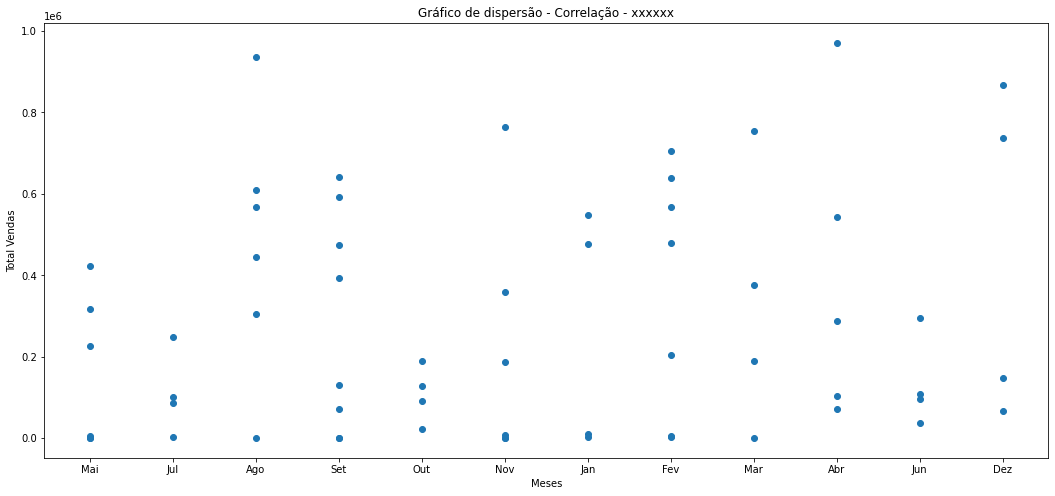

In [1750]:
# Visualizar dados em grafico de dispersão
# Onde X mes (VI-variavel independente) e
#      Y total de vendas (VD-varial dependente) 
x = df_mes['MES_EXT']
y = df_mes['VL_VENDA_TOT']

plt.scatter(x, y)
plt.title('Gráfico de dispersão - Correlação - xxxxxx')
plt.xlabel('Meses')
plt.ylabel('Total Vendas')
plt.grid(False)
plt.show()
    

In [1751]:
# ANALISE DA NORMALIDADE

    # OBS: Antes de realizar a analise do nivel de correlacao, precisamos analisar a normalidade, pois precisamos identificar 
    # qual sera o mteodo referente ao tipo de correlacao
    #      se sera aplicada: PEARSON, SPEARMAN ou KENDALL, e isso depende se passara no teste de normalidade ou NAO.
    #
    #      Se passar no teste da NORMALIDADE, nos podemos utilizar o coeficiente de PEARSON
    #      Se nao passar nos vamos utilizar SPEARMAN ou KENDALL
    #
    #      SPERMAN - serve para correlacao LINEAR ou NAO LINEAR
    #      KENDALL - utilizamos quando temos um grande numero de valores iguais e poucos registros (30 linhas)

    # O grafico histograma funciona bem para anvaliarmos a normalidade quando a distribuicao é NORMAL
    # agora quando a distribuicao náo é NORMAL, nós ficamos na duvida, com isso temos outro tipo de grafico chamado QQ-PLOT
    # que consegue nos informar com clareza e precisao a NORMALIDADE, ele é proprio para esta tarefa
    # temos tambem teste numericos como o "Teste Shapiro-Wilk"

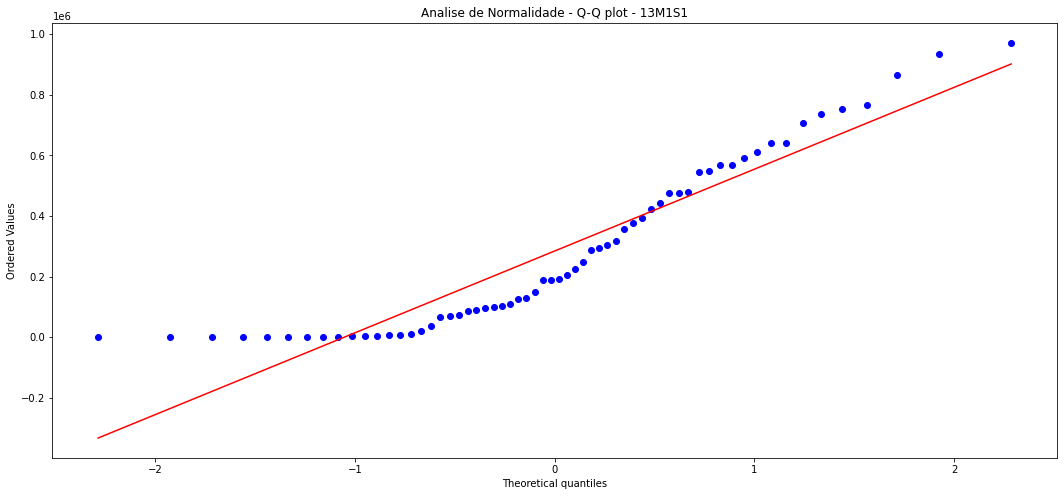

In [1752]:
stats.probplot(df_mes['VL_VENDA_TOT'], dist="norm", plot=plt)
plt.title("Analise de Normalidade - Q-Q plot - 13M1S1")
plt.show()

In [1753]:
# O resultado do grafico com varios pontos azuis proximos da reta vermelha indica que eh uma distribuicao NORMAL

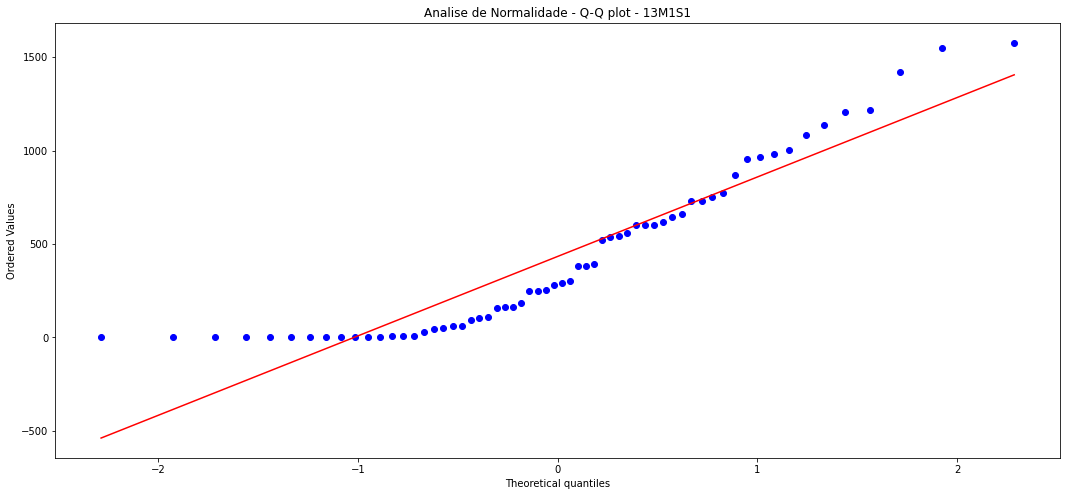

In [1754]:
stats.probplot(df_mes['QUANTIDADE'], dist="norm", plot=plt)
plt.title("Analise de Normalidade - Q-Q plot - 13M1S1")
plt.show()

In [1755]:
# Pelo resultado de ambos os graficos para VL_VENDA_TOT, QUANTIDADE, observamos que os pontos azuis estao bem proximos a 
# linha vermelha, ou seja, trata-se de uma
# distribuicao NORMAL desta forma podemos utilizar o coeficiente de PEARSON.

# olhar somente o grafico se torna um pouco subjetivo, desta forma temos
# outras formas de confrontar os valores com resultados numericos  "Teste Shapiro-Wilk"
# para termos argumentos que a distribuicao é NORMAL ou NAO.

# No teste de hipotese, temos Ho = que significa H zero ou hipotese NULA e temos a Ha = Hipotese Alternativa
# Ho = distribuição normal        :   p > 0.05
# Ha = distribuição != normal     :   p <= 0.05


In [1756]:
print('Teste Shapiro-Wilk  para analise de Normalidade - 0-B051')
estatistica, p = stats.shapiro(df_mes['VL_VENDA_TOT'])
print('Estatística do teste SHAPIRO: {}'.format(estatistica))
print('p-valor SHAPIRO: {}'.format(p))

Teste Shapiro-Wilk  para analise de Normalidade - 0-B051
Estatística do teste SHAPIRO: 0.8806207776069641
p-valor SHAPIRO: 2.1068375644972548e-05


In [1757]:
# o primeiro retorno é a ESTATISTICA DO TESTE
# o segundo retorno  é o resultado do SHAPIRO, PVALUE que é a referencia que nós precisamos
# como o PVALUE é maior que 0.05 significa que se trata de uma distribuição NORMAL
# com isso a hipotese NULA foi aceita

In [1758]:
# Além do teste do SHAPIRO temos o teste Lilliefors que utiliza o modelo Kolmogorov_Sminorv
# Teste Lilliefors (Kolmogorov_Sminorv)
# Ho = distribuição normal        :   p > 0.05
# Ha = distribuição != normal     :   p <= 0.05

In [1759]:
    import statsmodels
    from statsmodels.stats.diagnostic import lilliefors

    print('Teste Lilliefors para analise de Normalidade - 13M1S1')
    estatistica, p = statsmodels.stats.diagnostic.lilliefors(df_mes['VL_VENDA_TOT'], dist='norm')
    print('Estatística de teste lilliefors : {}'.format(estatistica))
    print('p-valor: {}'.format(p))


Teste Lilliefors para analise de Normalidade - 13M1S1
Estatística de teste lilliefors : 0.16059397595991004
p-valor: 0.0009999999999998899


In [1760]:
# Correlação Linear
#

# ----------------------------------------------------------------------------------------------------------------------
# Aplicamos Pearson quando (distribuição normal) e todas as variaveis sao numericas quantitativas

# var QUANTITATIVA X   var QUANTITATIVA
# com DIST. NORMAL     com DIST. NORMAL
# ----------------------------------------------------------------------------------------------------------------------

# ----------------------------------------------------------------------------------------------------------------------
# Aplicamos Spearman quando (distribuição com ou sem distribuicao normal)

# var QUANTITATIVA X   var QUANTITATIVA
# com DIST. NORMAL     sem DIST. NORMAL

# var QUANTITATIVA X   var QUANTITATIVA
# sem DIST. NORMAL     sem DIST. NORMAL

# var QUANTITATIVA          X   var QUALITATIVA ORDINAL
# com ou sem DIST. NORMAL       

# var QUALITATIVA ORDINAL   X   var QUALITATIVA ORDINAL
# ----------------------------------------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------------------------------------
# Aplicamos Kendall quando (distribuição não normal com quantidade pequena de amostras)

# ----------------------------------------------------------------------------------------------------------------------


# Ao analisarmos o coeficiente de pearson, as hipoteses são
# Ho = não há corrrelação linear: p > 0,05
# Ha = existe correlação linear: p <= 0,05

# def pearsonr(x, y):
# variavel x = independente
# variavel y = dependente

In [1761]:
print('Utilizando o coeficiente de PEARSON para validar se existe Correlação Linear - 0-B051')
coef, p = stats.pearsonr(df_mes['MES'], df_mes['VL_VENDA_TOT'])
print('Coeficiente de correlação PEARSON com MES : {}'.format(coef))
print('p-valor: {}'.format(p))

Utilizando o coeficiente de PEARSON para validar se existe Correlação Linear - 0-B051
Coeficiente de correlação PEARSON com MES : -0.03152126957716464
p-valor: 0.8078442407526736


In [1762]:
coef, p = stats.pearsonr(df_mes['QUANTIDADE'], df_mes['VL_VENDA_TOT'])
print('Coeficiente de correlação PEARSON com QUANTIDADE : {}'.format(coef))
print('p-valor: {}'.format(p))

Coeficiente de correlação PEARSON com QUANTIDADE : 0.9464463717798381
p-valor: 3.759133217399621e-31


In [1763]:
print('Utilizando o coeficiente de SPEARMAN para validar se existe Correlação Linear - 13M1S1')
coef, p = stats.spearmanr(df_mes['MES'], df_mes['VL_VENDA_TOT'])
print('Coeficiente de correlação SPEARMAN com MES : {}'.format(coef))
print('p-valor: {}'.format(p))



Utilizando o coeficiente de SPEARMAN para validar se existe Correlação Linear - 13M1S1
Coeficiente de correlação SPEARMAN com MES : -0.04923110701285823
p-valor: 0.7039545479910251


In [1764]:
print('Utilizando o coeficiente de SPEARMAN para validar se existe Correlação Linear - 13M1S1')
coef, p = stats.spearmanr(df_mes['QUANTIDADE'], df_mes['VL_VENDA_TOT'])
print('Coeficiente de correlação SPEARMAN com QUANTIDADE : {}'.format(coef))
print('p-valor: {}'.format(p))

Utilizando o coeficiente de SPEARMAN para validar se existe Correlação Linear - 13M1S1
Coeficiente de correlação SPEARMAN com QUANTIDADE : 0.9696981361886025
p-valor: 1.9954706640894314e-38


In [1765]:
# A importancia do teste de normalidade se faz necessario para decidirmos qual o coeficiente de correlacao será usado, 
# neste caso o PEARSON foi muito
# bem pois teve 97% de correlacao quando relacionado com a QUANTIDADE

In [1766]:
# Agora que ja sabemos qual metodo utilizar, ou seja, metodo PEARSON, é possível verificar todas as correlacoes do dataframe

In [1767]:
print('MATRIZ Correlação entre os campos do dataframe - metodo PEARSON')
correlacoes = df_mes.corr(method='pearson')
correlacoes

MATRIZ Correlação entre os campos do dataframe - metodo PEARSON


,MES,IPCA,QUANTIDADE,VL_VENDA_TOT,CMV_TOTAL,PERC_MARGEM,VL_VENDA_UNIT
MES,1.000000,-0.311879,-0.072328,-0.031521,-0.044646,-0.078888,-0.096026
IPCA,-0.311879,1.000000,0.314897,0.259637,0.289165,-0.234817,-0.282186
QUANTIDADE,-0.072328,0.314897,1.000000,0.946446,0.987123,-0.418123,-0.547057
VL_VENDA_TOT,-0.031521,0.259637,0.946446,1.000000,0.979964,-0.265627,-0.419480
CMV_TOTAL,-0.044646,0.289165,0.987123,0.979964,1.000000,-0.367892,-0.492861
PERC_MARGEM,-0.078888,-0.234817,-0.418123,-0.265627,-0.367892,1.000000,0.877272
VL_VENDA_UNIT,-0.096026,-0.282186,-0.547057,-0.419480,-0.492861,0.877272,1.000000


In [1768]:
print('MATRIZ Correlação entre os campos do dataframe - metodo SPEARMAN')
correlacoes = df_mes.corr(method='spearman')
correlacoes

MATRIZ Correlação entre os campos do dataframe - metodo SPEARMAN


,MES,IPCA,QUANTIDADE,VL_VENDA_TOT,CMV_TOTAL,PERC_MARGEM,VL_VENDA_UNIT
MES,1.000000,-0.320354,-0.072505,-0.049231,-0.076240,-0.054693,-0.079220
IPCA,-0.320354,1.000000,0.320230,0.276440,0.295551,-0.241976,-0.297526
QUANTIDADE,-0.072505,0.320230,1.000000,0.969698,0.990757,-0.507851,-0.580185
VL_VENDA_TOT,-0.049231,0.276440,0.969698,1.000000,0.988567,-0.350306,-0.416887
CMV_TOTAL,-0.076240,0.295551,0.990757,0.988567,1.000000,-0.451459,-0.507215
PERC_MARGEM,-0.054693,-0.241976,-0.507851,-0.350306,-0.451459,1.000000,0.948176
VL_VENDA_UNIT,-0.079220,-0.297526,-0.580185,-0.416887,-0.507215,0.948176,1.000000


In [1769]:
# Observe que temos uma baixa correlacao entre as variaveis MES e TOTAL VENDAS
# e temos uma ALTA correlacao entre QUANTIDADE e TOTAL VENDAS

In [1770]:
#mapa = df_mes.drop(["ANO", "MES", "MES_EXT", "IPCA", "QUANTIDADE", "VL_VENDA_TOT", "CMV_TOTAL"], axis=1)
mapa = df_mes.drop(["ANO", "MES", "MES_EXT", "IPCA"], axis=1)
#mapa = df_mes
#correlacoes = mapa.corr(method='spearman')
correlacoes = mapa.corr(method='pearson')

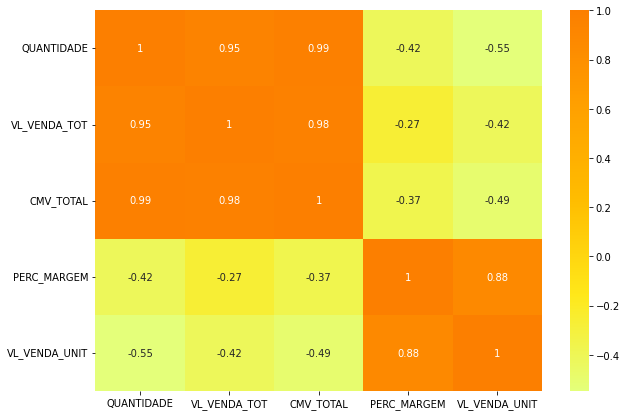

In [1771]:
# Avaliar a correlacao entre as variaveis de forma grafica
plt.figure(figsize=(10, 7))
sns.heatmap(correlacoes, annot=True, cmap="Wistia")
plt.show()
# O mapa de calor tambem podemos observar a correlacao entre as variaveis

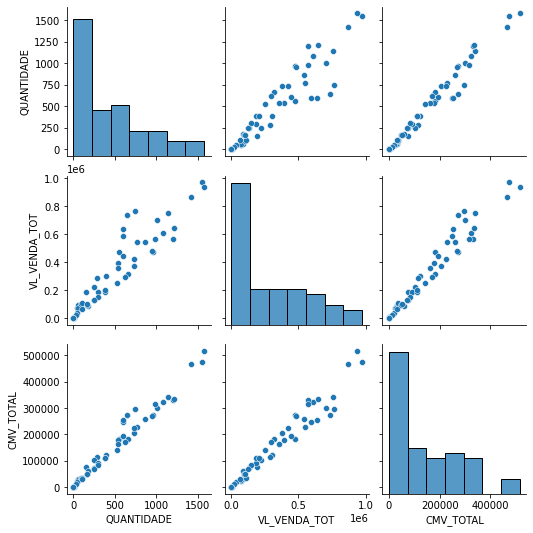

In [1772]:
# O seaborn, plota varias graficos com varias correlacoes de uma unica vez
mapa = df_mes.drop(["ANO", "MES", "MES_EXT", "IPCA", "VL_VENDA_UNIT", "PERC_MARGEM"], axis=1)
sns.pairplot(mapa)
plt.show()

In [1773]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
################################## CROSS-VALIDATION ####################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################

# Validação Cruzada (Cross-Validation) ----------------------------------------------------------------------------------

# O metodo de validacao cruzada ira realizar uma serie de SPLIT (KFold) em seus datasets (nao apenas 70% e 30%) 
# mas sim em varios pedacos,
# justamente para ter uma validacao mais efetiva
# da acuracia do seu modelo
# isso é necessario pois não é possível garantir que o percentual de 70/30 é o melhor para testar o seu modelo
# normalmente o seu data-frame é divido em 10 partes diferentes, mantendo sempre uma parte que náo será vista,
# desta forma o modelo nao ficara viciado, por isso do nome de validacao cruzada
# no final obtemos uma media de qual sera o desempenho do modelo em dados do mundo real que nunca foram analisados
# o SPLIT TEST é muito bom mas o CROSS-VALIDATION é melhor

In [1774]:
#from sklearn.ensemble import (AdaBoostClassifier,
#                              GradientBoostingClassifier,
#                              ExtraTreesClassifier,
#                              RandomForestClassifier)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import datasets, linear_model

# instanciar o objeto kfold a partir da classe KFold, com 10 divisoes do data-frame e um seed = 7459
seed = 7459
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

In [1775]:
#!pip install openpyxl
from openpyxl import Workbook

In [1776]:
# Criandos dataframes para o eixo X e Y
#y = df_mes[["VL_VENDA_TOT"]]

y = np.squeeze(df_mes[["VL_VENDA_TOT"]].astype('int'))

# O paraemtro y deve ser convertido para de data-frame para array com o metodo squeeze, caso contrario ocorre o erro abaixo
# Warning A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


# Alem disso deve ser convertido de float para inteiro, caso contrario ocorre o erro abaixo
# cross_val_score raise ValueError("Unknown label type: %r" % y_type)  ValueError: Unknown label type: 'continuous'


# no eixo X deve-se eliminar a variavel dependente VL_VENDA_TOT, variavel do tipo string MES_EXT
x = df_mes.drop(["ANO", "MES", "MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)


#x['CMV_TOTAL'] = x['CMV_TOTAL'].astype('int')
#x['PERC_MARGEM'] = x['PERC_MARGEM'].astype('int')
#x['IPCA'] = x['IPCA'].astype('int')
#x = x.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)

# O dataset sera separado em 70% para treinamento e 30% para teste, para avaliar o modelo test_size=0.3

seed = 746
X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

print('dataframe completo -------------------------------')
print(df_mes)
df_mes.to_excel(r'c:\windows\temp\df_mes_' + sIT_CODIGO + '.xlsx', index = True)


print('y-train ------------------------------------------')
print(type(y_train))
print(y_train.shape)
print(y_train.to_frame())
y_train.to_frame().to_excel(r'c:\windows\temp\y_train_' + sIT_CODIGO + '.xlsx', index = True)

print('y-test ------------------------------------------')
print(type(y_test))
print(y_test.shape)
print(y_test)
y_test.to_frame().to_excel(r'c:\windows\temp\y_test_' + sIT_CODIGO + '.xlsx', index = True)

print('x-train ------------------------------------------')
print(type(X_train))
print(X_train.shape)
print(X_train)
X_train.to_excel(r'c:\windows\temp\X_train_' + sIT_CODIGO + '.xlsx', index = True)

print('x-test ------------------------------------------')
print(type(x_test))
print(x_test.shape)
print(x_test)
x_test.to_excel(r'c:\windows\temp\x_test_' + sIT_CODIGO + '.xlsx', index = True)


dataframe completo -------------------------------
     ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0   2006    5  0.10           1       1095.65     504.62     Mai    53.943321    1095.650000
2   2006    7  0.19           2       3443.48    1034.84     Jul    69.947843    1721.740000
3   2006    8  0.05           1        869.57     447.47     Ago    48.541233     869.570000
4   2006    9  0.21          50      72655.44   22373.25     Set    69.206366    1453.108800
5   2006   10  0.33          63      91265.97   31300.65     Out    65.703920    1448.666190
6   2006   11  0.31           4       6846.26    1987.34     Nov    70.971888    1711.565000
7   2007    1  0.44           1       1869.57     496.84     Jan    73.424905    1869.570000
8   2007    2  0.44           2       2791.30     964.88     Fev    65.432594    1395.650000
9   2007    3  0.37         160     190310.96   77190.30     Mar    59.439908    1189.443500
10  2007    4  0.25

LinearRegression(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto  31K
[21469.27326117 23447.62480278 19280.71741315 27350.71207897
  7943.0233047  45234.65171821 29748.97938482 26677.12590712
 33603.35300191 61590.21940561]
29634.56802784402
coef_      -> [ 6.95692433e+03 -4.27877210e+02  3.41182066e+00  1.76316529e+03] 
intercept_ -> -96841.6426204624 
--- PREDICAO CROSS VALIDATION-----------------------------------------------------------
Cross-Predicted r2_score
r2_score: 0.9872523859985504
Cross-Predicted Erro Quadrático Médio (MSE-Mean squared error) Score 
(MSE-Mean squared error): 852703015.7088996
Cross-Predicted Raiz quadrada do erro-médio (RMSE - Root-mean-square deviation) Score
(RMSE - Root-mean-square deviation): 29201.079016175063


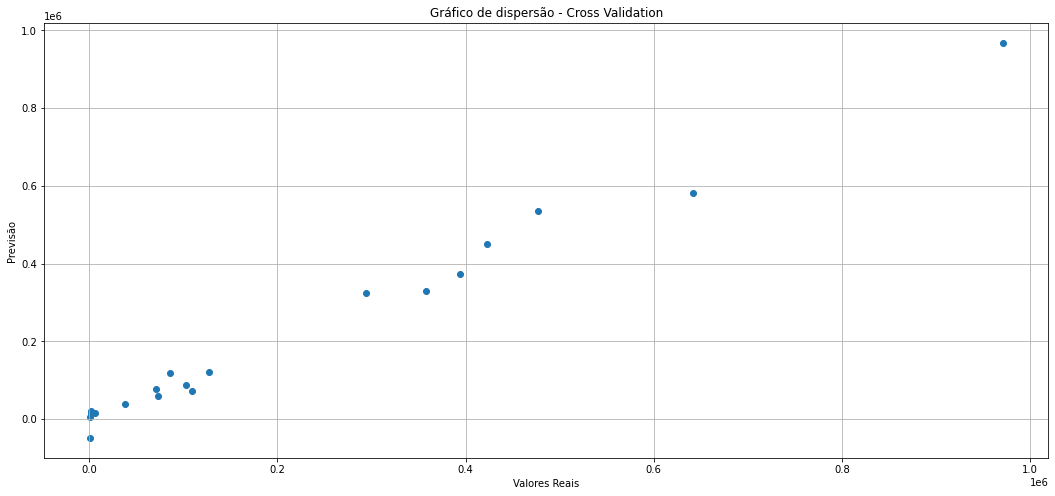

--- PREDICAO ISOLADA train_test_split---------------------------------------------------- inicio
train_test_split LinearRegression r2_score
r2_score: 0.9859701784769498
train_test_split LinearRegression Erro Quadrático Médio (MSE-Mean squared error) Score 
(MSE-Mean squared error): 938471397.1730015
train_test_split LinearRegression Raiz quadrada do erro-médio (RMSE - Root-mean-square deviation) Score
(RMSE - Root-mean-square deviation): 30634.480527226206


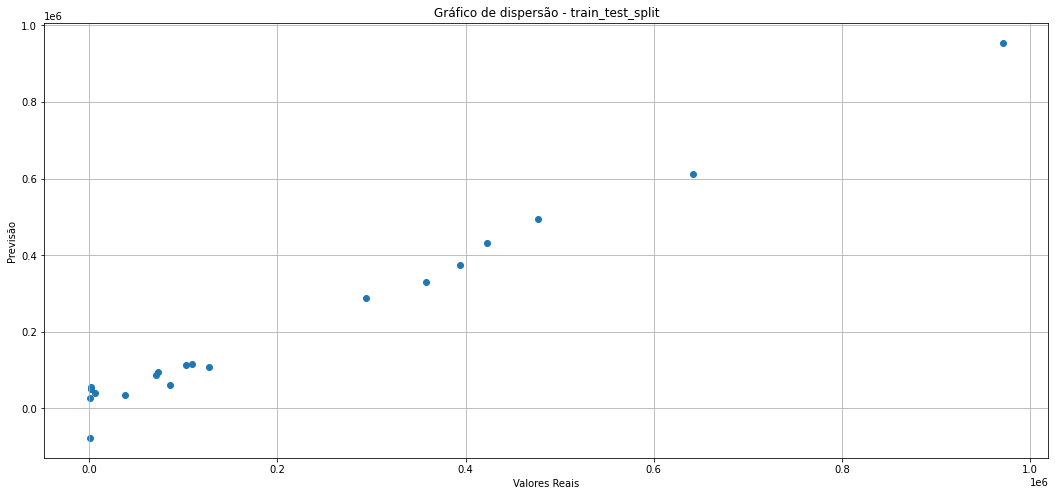

Score 0.9859701784769498
--- PREDICAO ISOLADA train_test_split---------------------------------------------------- fim
LinearRegression(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT,PERC_MARGEM media erro absoluto  31.9K
[26676.35447259 19170.17645746 19732.18082795 34571.0785715
 20478.76469526 44716.27536417 33039.55581286 26257.99924408
 35919.61543924 68833.03856789]
32939.503945298886
LinearRegression(): Eliminando MES_EXT,VL_VENDA_TOT media erro absoluto  26.2K 
[13641.92650256 40678.95404096 11630.77416604 25613.97931448
  9114.66225198 41640.3249011  21593.98212898 28445.83031503
 26482.08099275 55216.02631782]
27405.854093170696
LinearRegression(): Eliminando ANO,MES,MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto 28K
[21469.27326117 23447.62480278 19280.71741315 27350.71207897
  7943.0233047  45234.65171821 29748.97938482 26677.12590712
 33603.35300191 61590.21940561]
29634.56802784402


In [1777]:
# LINEAR REGRESSION

linear_reg = linear_model.LinearRegression()

x = df_mes.drop(["ANO", "MES", "MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)

print('LinearRegression(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto  31K')
scores = cross_val_score(linear_reg, x, y, cv=kfold, scoring='neg_mean_absolute_error')
print(-scores)
# media do erro medio absoluto
print(-scores.mean())


# Treinar
model = linear_reg.fit(x, y)

print('coef_      -> {} '.format(model.coef_))
print('intercept_ -> {} '.format(model.intercept_))





# Make cross validated predictions usando kfold
predictions = cross_val_predict(model, x_test, y_test, cv=kfold)

print('--- PREDICAO CROSS VALIDATION-----------------------------------------------------------')
#print(y_test)
#print(predictions)

#for elem in predictions:
#    print('Floating point numbers: %10.2f' %(elem))


print('Cross-Predicted r2_score')
print('r2_score: {}'.format(metrics.r2_score(y_test, predictions)))

print('Cross-Predicted Erro Quadrático Médio (MSE-Mean squared error) Score ')
print(f'(MSE-Mean squared error): {metrics.mean_squared_error(y_test, predictions, squared=True)}')

print('Cross-Predicted Raiz quadrada do erro-médio (RMSE - Root-mean-square deviation) Score')
print(f'(RMSE - Root-mean-square deviation): {metrics.mean_squared_error(y_test, predictions, squared=False)}')    

#plt.scatter(y_test, predictions)
    
plt.title('Gráfico de dispersão - Cross Validation')
plt.scatter(y_test, predictions)    
plt.xlabel("Valores Reais")
plt.ylabel("Previsão")
plt.grid(True)
plt.show()


# Predicao isolada 
print('--- PREDICAO ISOLADA train_test_split---------------------------------------------------- inicio')
# Treinar
model = linear_reg.fit(X_train, y_train)

resultado = model.predict(x_test) 
#print(y_test)
#print(resultado)
    
print('train_test_split LinearRegression r2_score')
print(f'r2_score: {metrics.r2_score(y_test, resultado)}')  

print('train_test_split LinearRegression Erro Quadrático Médio (MSE-Mean squared error) Score ')
print(f'(MSE-Mean squared error): {metrics.mean_squared_error(y_test, resultado, squared=True)}')

print('train_test_split LinearRegression Raiz quadrada do erro-médio (RMSE - Root-mean-square deviation) Score')
print(f'(RMSE - Root-mean-square deviation): {metrics.mean_squared_error(y_test, resultado, squared=False)}')    

plt.title('Gráfico de dispersão - train_test_split')
plt.scatter(y_test, resultado)
plt.xlabel("Valores Reais")
plt.ylabel("Previsão")
plt.grid(True)
plt.show()

print('Score {}'.format(model.score(x_test, y_test)))
print('--- PREDICAO ISOLADA train_test_split---------------------------------------------------- fim')

    
#aplicar o conceito de features eliminando atributos para ver se melhora o erro absoluto
#https://www.youtube.com/watch?v=CWxaXyXZ-1A
    
    
# no eixo X deve-se eliminar a variavel dependente VL_VENDA_TOT, variavel do tipo string MES_EXT e PERC_MARGEM
x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT", "PERC_MARGEM"], axis=1)    

print('LinearRegression(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT,PERC_MARGEM media erro absoluto  31.9K')
scores = cross_val_score(linear_reg, x, y, cv=kfold, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean())    
    
    
# no eixo X eliminando somente VL_VENDA_TO e MES_EXT (porem foi mantido VL_VENDA_UNIT nao eh correto)
x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT"], axis=1)    
print('LinearRegression(): Eliminando MES_EXT,VL_VENDA_TOT media erro absoluto  26.2K ')
scores = cross_val_score(linear_reg, x, y, cv=kfold, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean())       
 

# no eixo X deve-se eliminar a variavel dependente VL_VENDA_TOT, variavel do tipo string MES_EXT e PERC_MARGEM
x = df_mes.drop(["ANO", "MES", "MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)    

print('LinearRegression(): Eliminando ANO,MES,MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto 28K')
scores = cross_val_score(linear_reg, x, y, cv=kfold, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean())    




     ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0   2006    5  0.10           1       1095.65     504.62     Mai    53.943321    1095.650000
2   2006    7  0.19           2       3443.48    1034.84     Jul    69.947843    1721.740000
3   2006    8  0.05           1        869.57     447.47     Ago    48.541233     869.570000
4   2006    9  0.21          50      72655.44   22373.25     Set    69.206366    1453.108800
5   2006   10  0.33          63      91265.97   31300.65     Out    65.703920    1448.666190
6   2006   11  0.31           4       6846.26    1987.34     Nov    70.971888    1711.565000
7   2007    1  0.44           1       1869.57     496.84     Jan    73.424905    1869.570000
8   2007    2  0.44           2       2791.30     964.88     Fev    65.432594    1395.650000
9   2007    3  0.37         160     190310.96   77190.30     Mar    59.439908    1189.443500
10  2007    4  0.25          60      71366.61   28375.08     Abr    60

77  0.18           1     321.90    74.001325
    VL_VENDA_TOT
0        1095.65
2        3443.48
3         869.57
4       72655.44
5       91265.97
6        6846.26
7        1869.57
8        2791.30
9      190310.96
10      71366.61
11       1704.35
12     591071.30
13       1304.35
14      10453.32
15       6097.74
17     102735.85
18       4718.65
19     108890.40
20      85420.22
21     304889.61
22     474747.05
24     765252.50
25     736257.94
27     639972.00
28       1186.70
29     287359.34
30     225593.10
31      37680.68
33     444085.20
34     394171.58
35     188585.58
36     358162.34
37      67709.11
38     547590.39
39     704698.92
40     753319.42
41     543969.63
45     609379.18
46     130322.35
48     187793.99
49     148730.88
50     476770.57
51     479324.96
52     376022.98
54     316689.93
55     294453.82
56     249234.27
57     567911.20
58     641882.85
59     127111.11
63     203622.41
65     971110.74
66     422303.74
67      96823.91
68     100146.43
69 

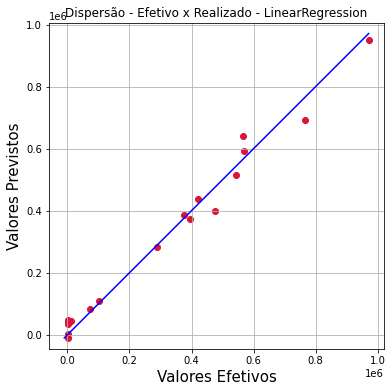

In [1778]:
####  TESTANDO REGRESSAO MULTIPLA COM OLS E SEM OLS

# Criandos dataframes para o eixo X e Y
# no eixo X deve-se eliminar a variavel dependente VL_VENDA_TOT, VL_VENDA_UNIT, variavel do tipo string MES_EXT
print(df_mes)
y = df_mes[["VL_VENDA_TOT"]]
x = df_mes.drop(["ANO", "MES", "MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)
print(x)
print(y)


# Nos testes realizados, ficou evidenciado que ao excluir as variaveis ANO e MES que possuem baixa correlacao
# com o valor total de venda, o algoritmo apresentou melhor desempenho quanto ao R2


# O dataset sera separado em 70% para treinamento e 30% para teste, para avaliar o modelo test_size=0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=749)


# Instanciar
modelo_regressaolinear = LinearRegression()

# Treinar
modelo_regressaolinear.fit(x_train, y_train)


# Predicao SEM OLS
previsao_regressaolinear = modelo_regressaolinear.predict(x_test)

print('********** Parametros funcao linear ********************************')
print('intercept_ -> {} '.format(modelo_regressaolinear.intercept_))
print('coef_      -> {} '.format(modelo_regressaolinear.coef_))





print('********************** previsao_regressaolinear SEM OLS *******************************')
print(previsao_regressaolinear)
print('********************** previsao_regressaolinear SEM OLS *******************************')
print(type(previsao_regressaolinear))

# Vamos usar o R² -> diz o % que o nosso modelo consegue explicar o que acontece
# verificar acuracia do modelo
print(f'LinearRegression: {metrics.r2_score(y_test, previsao_regressaolinear)}')


# Copiando dataframe para outro
df_result=y_test.copy()

# adicionar coluna ao dataframe df_result
df_result['VL_PREVISTO_ALGORITMO']=0

print(df_result)
print('***************************************************************************************************')

j = 0
for index,v in y_test['VL_VENDA_TOT'].iteritems():
    print('y_test index-> {} , y_test VL_VENDA_TOT -> {} , predicao {} '.format(index,v, previsao_regressaolinear[j]))
    if index in df_result.index:
        df_result['VL_PREVISTO_ALGORITMO'][index]=previsao_regressaolinear[j]
    j+=1

# adicionar coluna ao dataframe df_result subtraindo VL_VENDA_TOT, VL_PREVISTO_ALGORITMO     
df_result['VL_RESIDUO']=df_result['VL_PREVISTO_ALGORITMO']-df_result['VL_VENDA_TOT']
    
print(df_result.sort_index())    
df_result.sort_index().to_excel(r'c:\windows\temp\testando_formula_residuos_LR-' + sIT_CODIGO + '.xlsx', index = True)

# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_result['VL_PREVISTO_ALGORITMO']))
true_value = tuple(list(df_result['VL_VENDA_TOT']))

plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Dispersão - Efetivo x Realizado - LinearRegression')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()






    


                            OLS Regression Results                            
Dep. Variable:           VL_VENDA_TOT   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     726.9
Date:                Sun, 20 Nov 2022   Prob (F-statistic):           3.57e-48
Time:                        08:43:41   Log-Likelihood:                -742.53
No. Observations:                  62   AIC:                             1495.
Df Residuals:                      57   BIC:                             1506.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.684e+04   3.52e+04     -2.748      

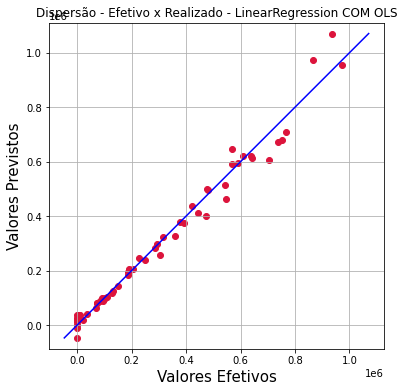

In [1779]:
############## PREVISAO COM OLS
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

#regressao = smf.ols('VL_VENDA_TOT ~ QUANTIDADE', data=df_mes).fit()
#regressao = smf.ols('VL_VENDA_TOT ~ IPCA + QUANTIDADE + CMV_TOTAL + PERC_MARGEM', data=df_mes).fit()
regressao = smf.ols('VL_VENDA_TOT ~ IPCA + QUANTIDADE + CMV_TOTAL + PERC_MARGEM', data=df_mes).fit()
print(regressao.summary())
print(regressao.params)
print(regressao.fittedvalues)

# Convertendo de  pandas.core.series.Series  para <class 'numpy.ndarray'>
previsao_regressaolinear = regressao.fittedvalues.to_numpy()
#print(type(previsao_regressaolinear))



# Copiando dataframe para outro
df_result=df_mes.copy()

# adicionar coluna ao dataframe df_result
df_result['VL_PREVISTO_ALGORITMO']=0

print('***************************************************************************************************')
print(df_result)

j = 0
for index,v in df_mes['VL_VENDA_TOT'].iteritems():
    print('df_mes index-> {} , df_mes VL_VENDA_TOT -> {} , predicao {} '.format(index,v, previsao_regressaolinear[j]))
    if index in df_result.index:
        df_result['VL_PREVISTO_ALGORITMO'][index]=previsao_regressaolinear[j]
    j+=1

# adicionar coluna ao dataframe df_result subtraindo VL_VENDA_TOT, VL_PREVISTO_ALGORITMO     
df_result['VL_RESIDUO']=df_result['VL_PREVISTO_ALGORITMO']-df_result['VL_VENDA_TOT']

print('***************************************************************************************************')
print(df_result)
    

    
# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_result['VL_PREVISTO_ALGORITMO']))
true_value = tuple(list(df_result['VL_VENDA_TOT']))

plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Dispersão - Efetivo x Realizado - LinearRegression COM OLS')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()
    


In [1780]:
print(regressao.summary())

                            OLS Regression Results                            
Dep. Variable:           VL_VENDA_TOT   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     726.9
Date:                Sun, 20 Nov 2022   Prob (F-statistic):           3.57e-48
Time:                        08:43:41   Log-Likelihood:                -742.53
No. Observations:                  62   AIC:                             1495.
Df Residuals:                      57   BIC:                             1506.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.684e+04   3.52e+04     -2.748      

In [1781]:
print(df_mes.head())
print(df_mes)
residuos = regressao.resid
print(residuos)
print(previsao_regressaolinear)

    ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0  2006    5  0.10           1       1095.65     504.62     Mai    53.943321     1095.65000
2  2006    7  0.19           2       3443.48    1034.84     Jul    69.947843     1721.74000
3  2006    8  0.05           1        869.57     447.47     Ago    48.541233      869.57000
4  2006    9  0.21          50      72655.44   22373.25     Set    69.206366     1453.10880
5  2006   10  0.33          63      91265.97   31300.65     Out    65.703920     1448.66619
     ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0   2006    5  0.10           1       1095.65     504.62     Mai    53.943321    1095.650000
2   2006    7  0.19           2       3443.48    1034.84     Jul    69.947843    1721.740000
3   2006    8  0.05           1        869.57     447.47     Ago    48.541233     869.570000
4   2006    9  0.21          50      72655.44   22373.25     Set    69.20636

In [1782]:
residuos = regressao.resid
print(residuos)

0        836.372399
2     -27041.699990
3      10677.911162
4      -8926.263685
5      -9871.488490
6     -28673.345089
7     -35077.853385
8     -21233.348792
9     -15123.474704
10    -10883.292971
11    -31980.604829
12     -5638.066371
13    -25945.883684
14    -24881.368838
15    -21961.062529
17      2105.515889
18    -16361.171887
19      5497.004282
20     -2198.231361
21     47192.917122
22     75414.697751
24     56937.239033
25     65546.237328
27     18849.002153
28    -17960.444759
29      3566.645163
30    -20138.093837
31     -1801.920247
33     33827.907838
34     19620.143469
35      3106.672632
36     29636.548717
37      5126.491533
38     83154.625103
39     98645.461858
40     74687.042530
41     31307.946087
45    -12275.618083
46      3353.587266
48     -6420.878339
49      5826.299895
50    -24153.088602
51    -18468.640852
52     -3208.249672
54     -5805.100325
55     -3725.791404
56      9085.541272
57    -21915.628925
58     30109.813609
59     10618.643360


In [1783]:
# RandomForestRegressor

print('Aplicando outro metodo RandomForestRegressor..........................')
rf = RandomForestRegressor()


x = df_mes.drop(["ANO", "MES", "MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)

print('RandomForestRegressor(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto 40K')
scores = cross_val_score(rf, x, y, cv=kfold, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean())


model = rf.fit(x, y)

# RandomForestRegresssor nao posui coef E intercept
#print('coef_      -> {} '.format(model.coef_))
#print('intercept_ -> {} '.format(model.intercept_))

# Make cross validated predictions
predictions = cross_val_predict(model, x, y, cv=kfold)

#print(predictions)

#for elem in predictions:
#    print('Floating point numbers: %10.2f' %(elem))



Aplicando outro metodo RandomForestRegressor..........................
RandomForestRegressor(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto 40K
[33243.01597143 10111.01478571 27585.29283333 33152.12128333
 28713.01563333 38920.76053333 46808.24453333 33366.94998333
 83399.7256     39452.35131667]
37475.249247380954


In [1784]:
# SVR

#print('Aplicando outro metodo SVR..........................')
#from sklearn.svm import SVR
#svr = SVR(kernel='linear')

#x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)

#print('SVR(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto 28.9K porem demora cerca de 5 min')
#scores = cross_val_score(svr, x, y, cv=kfold, scoring='neg_mean_absolute_error')
#print(-scores)
#print(-scores.mean())



In [1785]:
# REGRESSAO POLINOMIAL.

print('Aplicando outro metodo REGRESSAO POLINOMIAL..........................')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


# Pré Processamento
pre_process = PolynomialFeatures(degree=2)
# Caso queira o grau 3 basta alterar o parametro degree

# variavel independente
#x = x_test[['QUANTIDADE']]

# variavel dependente
#y = y_test.VL_VENDA_TOT

x_poly = pre_process.fit_transform(x)
#print(x_poly)

# Criação do modelo
modelo_sk = LinearRegression()
#modelo_sk.fit(x_poly, y)
#previsao_regressaopolinomial = modelo_sk.predict(x_poly)

x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)

print('POLINOMIAL: Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto 10K')
scores = cross_val_score(modelo_sk, x_poly, y, cv=kfold, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean())


Aplicando outro metodo REGRESSAO POLINOMIAL..........................
POLINOMIAL: Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto 10K
[6856.45873684 5351.30879691 2843.93384474 3171.78598783 3217.37741068
 5126.93826554 9650.12754488 1672.81601882 6758.48876188 4653.21214731]
4930.2447515430185


In [1786]:
# AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

print('Aplicando outro metodo AdaBoostClassifier..........................')
ada = AdaBoostClassifier(n_estimators=200, random_state=123, learning_rate=0.1)
x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)
print('AdaBoostClassifier(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto  144K')
scores = cross_val_score(ada, x, y, cv=kfold, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean()) 


Aplicando outro metodo AdaBoostClassifier..........................
AdaBoostClassifier(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media erro absoluto  144K
[nan nan nan nan nan nan nan nan nan nan]
nan


In [1787]:
# LASSO regression 

print('Aplicando outro metodo LassoLars ....................................')
from sklearn.linear_model import LassoLars
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler

#lasso = make_pipeline(StandardScaler(with_mean=False), LassoLars(alpha=0.4, normalize=True))
lasso = LassoLars(normalize=True)

x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)
print('LassoLars(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media 31K')
scores = cross_val_score(lasso, x, y, cv=kfold, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean())


Aplicando outro metodo LassoLars ....................................
LassoLars(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media 31K
[24084.82600388 31542.31404367 20594.99906697 27860.10451442
  6128.97008743 44533.62619042 30926.20817894 27924.46006776
 34001.21306262 63471.34599709]
31106.806721320223


In [1788]:
# Ridge Regression Algorithm

print('Aplicando outro metodo Ridge ....................................')
from sklearn.linear_model import Ridge

rd = Ridge()

x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)
print('Ridge(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media 30k')
scores = cross_val_score(rd, x, y, cv=kfold, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean())


Aplicando outro metodo Ridge ....................................
Ridge(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media 30k
[23979.98853951 31353.44713318 20619.47195976 27854.45003814
  6123.92856152 44510.57365468 30637.35881076 27313.28246454
 33350.34355176 63593.68215675]
30933.65268706046


In [1789]:
# Elastic net regression

import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings('always')

print('Aplicando outro metodo Elastic net ....................................')
from sklearn.linear_model import ElasticNet

el = ElasticNet()

print('Ridge(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media 30k')
x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)

print('R2')
scores = cross_val_score(el, x, y, cv=kfold)
print(scores)
print(scores.mean())

print('neg_mean_absolute_error')
scores = cross_val_score(el, x, y, cv=kfold, scoring='neg_mean_absolute_error')
print(-scores)
print(-scores.mean())


model = el.fit(x, y)

print('coef_      -> {} '.format(model.coef_))
print('intercept_ -> {} '.format(model.intercept_))

# Make cross validated predictions
predictions = cross_val_predict(model, x, y, cv=kfold)

print(predictions)

for elem in predictions:
    print('Floating point numbers: %10.2f' %(elem))


Aplicando outro metodo Elastic net ....................................
Ridge(): Eliminando MES_EXT,VL_VENDA_TOT,VL_VENDA_UNIT media 30k
R2
[0.98987229 0.50755075 0.9646045  0.97783938 0.99828989 0.96285605
 0.96088559 0.98149441 0.97350921 0.89596895]
0.9212871018460062
neg_mean_absolute_error


c:\python\projects\cpsoracle02\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.604e+09, tolerance: 4.303e+08

c:\python\projects\cpsoracle02\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.604e+09, tolerance: 4.303e+08



[23699.72620385 30193.82253118 20576.36924499 27872.40839585
  5807.69799652 44386.54180792 29991.58996569 25996.36067376
 32238.61386167 63618.07797371]
30438.12086551435
coef_      -> [-1903.33114879    40.93727958   548.5618384   -414.08043088
     3.376197    1584.36485824] 
intercept_ -> [3739020.9363383] 
[ 8.47471917e+03  4.53927298e+04 -2.19770283e+02  8.09005500e+04
  1.07970556e+05  4.26004024e+04  3.98776637e+04  3.29215779e+04
  2.10766499e+05  8.95143905e+04  3.86893075e+04  5.97487719e+05
  2.71616846e+04  3.55220102e+04  2.94556764e+04  1.00098131e+05
  2.14097500e+04  1.06992522e+05  9.30585673e+04  2.62057159e+05
  3.98847613e+05  7.00131485e+05  6.48611660e+05  6.09134528e+05
  2.00001313e+04  2.75783137e+05  2.45357886e+05  4.11812249e+04
  4.06520838e+05  3.70124913e+05  1.93653490e+05  3.35577871e+05
  6.34525869e+04  4.46266125e+05  5.90223716e+05  6.73644934e+05
  5.12618289e+05  6.28763027e+05  1.27908778e+05  1.92827793e+05
  1.33759347e+05  5.02177426e+05  5.0

c:\python\projects\cpsoracle02\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.604e+09, tolerance: 4.303e+08



Cross-validated scores: [0.98981239 0.46816591 0.96360843 0.97798702 0.99849173 0.96262318
 0.95905412 0.98008725 0.9722471  0.89552397]
Cross-validated scores mean(): 0.916760108976783
Cross-validated scores neg_mean_absolute_error : [23981.847971   31528.32864501 20573.62629071 27817.59017902
  6094.16448149 44577.21988461 30950.63171208 27955.55007241
 33947.69975767 63529.51114232]
Cross-validated scores mean() neg_mean_absolute_error : 31095.617013632575
<class 'numpy.ndarray'>
[ 6.73559892e+03  4.69055312e+04 -7.14605461e+02  8.06858523e+04
  1.09340620e+05  4.41807768e+04  4.07278958e+04  3.36619559e+04
  2.10281775e+05  9.05642198e+04  3.84820150e+04  5.94673905e+05
  2.70580419e+04  3.74947013e+04  2.99334946e+04  1.01319682e+05
  2.84247041e+04  1.06561413e+05  9.46012844e+04  2.61647219e+05
  3.97474905e+05  7.00474761e+05  6.48393511e+05  6.09383570e+05
  1.76812495e+04  2.76491538e+05  2.45463628e+05  4.07684972e+04
  4.02707359e+05  3.67923502e+05  1.93636252e+05  3.36826

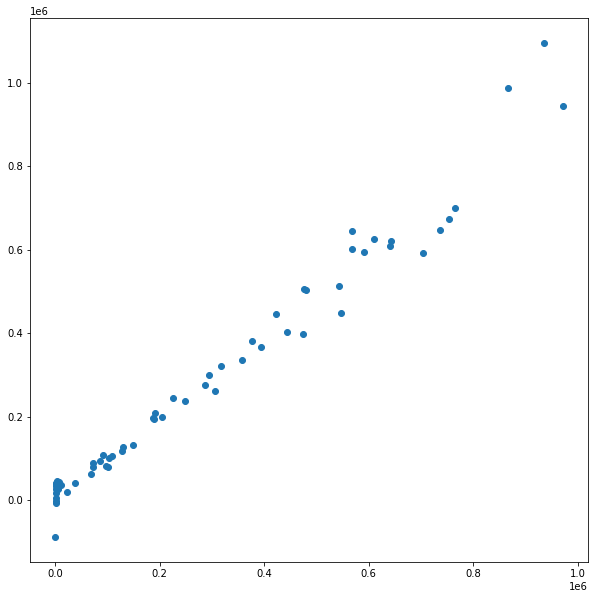

In [1790]:
# Utilizando cross_val_score e cross_val_predict com algoritmo linearRegression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from matplotlib import pyplot as plt

from sklearn import metrics

# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10

# Make plots show up!
#% matplotlib inline

x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)
y = np.squeeze(df_mes[["VL_VENDA_TOT"]].astype('int'))

# init our linear regression class / object
lm = LinearRegression()

# Fit our training data
model = lm.fit(x, y)

scores = cross_val_score(lm, x, y, cv=kfold, scoring='r2')
print('Cross-validated scores: {}'.format(scores))
print('Cross-validated scores mean(): {}'.format(scores.mean()))

scores = cross_val_score(lm, x, y, cv=kfold, scoring='neg_mean_absolute_error')
print('Cross-validated scores neg_mean_absolute_error : {}'.format(-scores))
print('Cross-validated scores mean() neg_mean_absolute_error : {}'.format(-scores.mean()))


# Make cross validated predictions
predictions = cross_val_predict(model, x, y, cv=kfold)
#print(y)
print(type(predictions))

print(predictions)
for elem in predictions:
    print('Floating point numbers: %10.2f' %(elem))


plt.scatter(y, predictions)
print('Cross-Predicted r2_score: {}'.format(metrics.r2_score(y, predictions)))

print('Cross-Predicted Erro Quadrático Médio (MSE-Mean squared error) Score ')
print(f'Cross-Predicted: {metrics.mean_squared_error(y, predictions, squared=True)}')

print('Cross-Predicted Raiz quadrada do erro-médio (RMSE - Root-mean-square deviation) Score')
print(f'Cross-Predicted: {metrics.mean_squared_error(y, predictions, squared=False)}')



In [1791]:
# instanciar um objeto ada a partir da classe AdaBoostClassifier, com 200 estimativas, seed=123 e taxa de aprendizagem = 0.1
# cada algoritmo possui seus respectivos parametros
#ada = AdaBoostClassifier(n_estimators=200, random_state=123, learning_rate=0.1)

#resultado = cross_val_score(ada, X_train, y_train, cv=kfold, scoring='accuracy')
#resultado = cross_val_predict(ada, X_train, y_train, cv=kfold)
#resultado = cross_val_predict(ada, X_train, y_train, cv=kfold)
#print(resultado)
#print(type(resultado))
#print(pd.DataFrame(resultado,columns = ['TOTAL_VENDA']))
#print('O score cross-validado do AdaBoost é:', resultado.mean())

#print('Accuracy -> {} '.format(metrics.accuracy_score(y_train, resultado)))
#print('f1 score macro -> {}'.format(metrics.f1_score(y_train, resultado, average='macro')))
#print('f1 score micro -> {}'.format(metrics.f1_score(y_train, resultado, average='micro')))
#print('precision score -> {}'.format(metrics.precision_score(y_train, resultado, average='macro')))
#print('recall score -> {}'.format(metrics.recall_score(y_train, resultado, average='macro')))
#print('hamming_loss -> {}'.format(metrics.hamming_loss(y_train, resultado)))
#print('classification_report -> {}'.format(metrics.classification_report(y_train, resultado)))
#print('jaccard_similarity_score -> {}'.format(metrics.jaccard_similarity_score(y_train, resultado)))
#print('log_loss -> {}'.format(metrics.log_loss(y_train, resultado)))
#print('zero_one_loss -> {}'.format(metrics.zero_one_loss(y_train, resultado)))
#print('AUC&ROC -> {}'.format(metrics.roc_auc_score(y_train, resultado)))
#print('matthews_corrcoef -> {}'.format(metrics.matthews_corrcoef(y_train, resultado)))



In [1792]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

lbl_encoder = LabelEncoder()

#target_var = df_mes["VL_VENDA_TOT"]
#print(target_var)

#all_data = df_mes.iloc[:,0:8]
#all_data = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)

#print(all_data)
#print(all_data.columns)

linear_reg = LinearRegression()

X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

linear_model = linear_reg.fit(X_train, y_train)


print('Intercept: {}'.format(linear_reg.intercept_))
print('Coef     : {}'.format(linear_reg.coef_))


prediction_price = linear_model.predict(x_test)
#print(prediction_price)
#print(type(prediction_price))
pd.DataFrame(prediction_price,columns = ['TOTAL_VENDA']).to_excel(r'c:\windows\temp\result_' + sIT_CODIGO + '.xlsx', index = True)

# O metrics.mean_absolute_error mostra o quanto o modelo esta errando para mais ou para menos
print('metrics.mean_absolute_error : {}'.format(metrics.mean_absolute_error(y_test, prediction_price)))
print('metrics.mean_squared_error  : {}'.format(metrics.mean_squared_error(y_test, prediction_price)))


kf = KFold(n_splits=10, shuffle=False)
kf.split(x)

metric_output = []

for train_index, test_index in kf.split(x):
    
    X_train = x.iloc[train_index]
    x_test  = x.iloc[test_index]
    
    y_train = y.iloc[train_index]    
    y_test  = y.iloc[test_index]
    
    linear_model = linear_reg.fit(X_train, y_train)
    prediction_price = linear_model.predict(x_test)
    root_mse = np.sqrt(metrics.mean_squared_error(y_test, prediction_price))
    metric_output.append(root_mse)

print(metric_output)    
np.mean(metric_output)    

Intercept: 3320880.323795227
Coef     : [-1689.8216795   -229.88933333  1035.08472428  -389.2491339
     3.33406524  1408.46300024]
metrics.mean_absolute_error : 27836.938018037472
metrics.mean_squared_error  : 1958508548.2371778
[35981.84655976742, 31707.98832213116, 23649.762127393347, 89977.63303673158, 23096.10299522291, 87194.31669094725, 18883.57278791877, 17017.106264987277, 66834.642529379, 72433.32327724266]


46677.62945917213

In [1793]:
# APLICANDO O CROSS-VALIDATION K-FOLD PARA O CONJUNTO DE DADOS ------------------------------------------------

In [1794]:
from sklearn.model_selection import cross_val_score # Cross Validation Function.
from sklearn.model_selection import KFold # KFold Class.
from sklearn.linear_model import LinearRegression # Linear Regression class.
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Cross-Validation models.
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [1795]:
import warnings
warnings.filterwarnings('ignore')

#y = np.squeeze(df_mes[["VL_VENDA_TOT"]])
#x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)

y = df_mes[["VL_VENDA_TOT"]]
x = df_mes.drop(["ANO", "MES", "MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)

# O dataset sera separado em 70% para treinamento e 30% para teste, para avaliar o modelo test_size=0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=745)

# Testar o CROSS-VALIDATION somente com a base de teste (EXTERNAL CROSS-VALIDATION)
c_file = r'c:\windows\temp\external-cross-validation-' + sIT_CODIGO + '.xlsx'
x = x_test.copy()
y = y_test.copy()

# Testar o CROSS-VALIDATION somente com a base de treinamento (INTERNAL CROSS-VALIDATION)
#c_file = r'c:\windows\temp\internal-cross-validation-' + sIT_CODIGO + '.xlsx'
#x = x_train.copy()
#y = y_train.copy()



# instanciar o objeto kfold a partir da classe KFold, com 10 divisoes do data-frame e um seed = 7459

model  = LinearRegression()

#kfold  = KFold(n_splits=5, shuffle=True) # shuffle=True, Shuffle (embaralhar) the data.

seed = 1
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)


result = cross_val_score(model, x, y, cv = kfold)

print("K-Fold (R^2) Scores: {0}".format(result))
print("Mean R^2 for Cross-Validation K-Fold: {0}".format(result.mean()))



# Definicação de funcao para comparar os resultados para 6 algoritimos diferentes.

# create an Empty DataFrame object
df_result_cv = pd.DataFrame()    


def ApplyesKfold(x_axis, y_axis, p_seed):
    #Linear Models.
    #print('x_axis -> {}  {}'.format(x_axis, y_axis))
    
    print('seed {}'.format(p_seed))
    

    # KFold settings.
    seed = p_seed
    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    
    # Axis
    x = x_axis
    y = y_axis

    # Models instances.
    linearRegression = LinearRegression()
    elasticNet       = ElasticNet()
    ridge            = Ridge()
    lasso            = Lasso()
    svr              = SVR(kernel='linear')
    rf               = RandomForestRegressor()

    
    # Applyes KFold to models.
    linearRegression_result    = cross_val_score(linearRegression, x, y, cv=kfold, scoring='r2')
    elasticNet_result          = cross_val_score(elasticNet, x, y, cv=kfold, scoring='r2')
    ridge_result               = cross_val_score(ridge, x, y, cv=kfold, scoring='r2')
    lasso_result               = cross_val_score(lasso, x, y, cv=kfold, scoring='r2')
    svr_result                 = cross_val_score(svr, x, y, cv=kfold, scoring='r2')
    rf_result                  = cross_val_score(rf, x, y, cv=kfold, scoring='r2')
    
    print(linearRegression_result)

    
    # Creates a dictionary to store Linear Models.
    dic_models_r2 = {
      "LinearRegression": linearRegression_result.mean(),
      "ElasticNet": elasticNet_result.mean(),
      "Ridge": ridge_result.mean(),
      "Lasso": lasso_result.mean(),
      "SVR": svr_result.mean(),
      "RandomForestRegressor": rf_result.mean()
    }    
    
    df_result_cv=pd.DataFrame.from_dict([dic_models_r2])
    df_result_cv['Seed']=p_seed
    df_result_cv['Scoring']='R2'
    df_result_cv['Item']=sIT_CODIGO
    
    # Select the best model
    bestModel = max(dic_models_r2, key=dic_models_r2.get)    
    
    print("""          Linear Regression Mean (R^2): {0}
          Elastic Net Mean (R^2): {1}
          Ridge Mean (R^2): {2}
          Lasso Mean (R^2): {3}
          SVR Mean (R^2): {4}
          Random Forest Mean (R^2): {5}""".format(linearRegression_result.mean(),
                                             elasticNet_result.mean(),
                                             ridge_result.mean(),
                                             lasso_result.mean(),
                                             svr_result.mean(),
                                             rf_result.mean()))
    
    print("The best model r2 is: {0} with value: {1}".format(bestModel, dic_models_r2[bestModel]))
    
    
    
    
    linearRegression_result_er = cross_val_score(linearRegression, x, y, cv=kfold, scoring='neg_mean_absolute_error')
    elasticNet_result_er       = cross_val_score(elasticNet, x, y, cv=kfold, scoring='neg_mean_absolute_error')
    ridge_result_er            = cross_val_score(ridge, x, y, cv=kfold, scoring='neg_mean_absolute_error')
    lasso_result_er            = cross_val_score(lasso, x, y, cv=kfold, scoring='neg_mean_absolute_error')
    svr_result_er              = cross_val_score(svr, x, y, cv=kfold, scoring='neg_mean_absolute_error')
    rf_result_er               = cross_val_score(rf, x, y, cv=kfold, scoring='neg_mean_absolute_error')

    
    # Creates a dictionary to store Linear Models.
    dic_models_mse = {
           "LinearRegression": -linearRegression_result_er.mean(),
           "ElasticNet": -elasticNet_result_er.mean(),
           "Ridge": -ridge_result_er.mean(),
           "Lasso": -lasso_result_er.mean(),
           "SVR": -svr_result_er.mean(),
           "RandomForestRegressor": -rf_result_er.mean()
    }    
    
    df_result_cv2=pd.DataFrame.from_dict([dic_models_mse])
    df_result_cv2['Seed']=p_seed
    df_result_cv2['Scoring']='MSE'
    df_result_cv2['Item']=sIT_CODIGO
    
    df_result_cv = df_result_cv.append(df_result_cv2, ignore_index=True)
    
    
    
    # Select the best model.
    bestModel = min(dic_models_mse, key=dic_models_mse.get)    
    
    
    print("""          Linear Regression Mean (MSE): {0}
          Elastic Net Mean (MSE): {1}
          Ridge Mean (MSE): {2}
          Lasso Mean (MSE): {3}
          SVR Mean (MSE): {4}
          Random Forest Mean (MSE):""".format(-linearRegression_result_er.mean(),
                                             -elasticNet_result_er.mean(),
                                             -ridge_result_er.mean(),
                                             -lasso_result_er.mean(),
                                             -svr_result_er.mean(),
                                             -rf_result_er.mean()))
    
    print("The best model MSE is: {0} with value: {1}".format(bestModel, dic_models_mse[bestModel]))
    
    return(df_result_cv)

# create an Empty DataFrame object
#df_cv = pd.DataFrame(columns=['LinearRegression','ElasticNet','Ridge','Lasso','SVR','RandomForestRegressor','Metric','seed'])

# create an Empty DataFrame object
df_cv = pd.DataFrame()

for num in range(745, 755):    
    z = ApplyesKfold(x, y, num)
    df_cv = df_cv.append(z, ignore_index=True)

print(df_cv)
df_cv.to_excel(c_file, index = True)

    


K-Fold (R^2) Scores: [  0.95808685   0.97092518   0.88551337 -16.47944496   0.89030046]
Mean R^2 for Cross-Validation K-Fold: -2.554923818336864
seed 745
[  0.97620574   0.97968472   0.9875251    0.9925091  -12.03799479]
          Linear Regression Mean (R^2): -1.6204140280443933
          Elastic Net Mean (R^2): -0.3739791316185926
          Ridge Mean (R^2): -0.6394389897478585
          Lasso Mean (R^2): -1.6189831045818515
          SVR Mean (R^2): 0.9688817897789139
          Random Forest Mean (R^2): -1.1025988157391962
The best model r2 is: SVR with value: 0.9688817897789139
          Linear Regression Mean (MSE): 21554.126123886865
          Elastic Net Mean (MSE): 18162.016900942835
          Ridge Mean (MSE): 19001.255991809714
          Lasso Mean (MSE): 21549.386660256976
          SVR Mean (MSE): 20489.745685533348
          Random Forest Mean (MSE):
The best model MSE is: ElasticNet with value: 18162.016900942835
seed 746
[0.95687142 0.98346444 0.99112988 0.98407309 0.957

In [1796]:
# HIPERPARAMETROS ------------------------------------------------------------------

In [1797]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression # Linear Regression class.

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

# Using GridSearchCV

x = df_mes.drop(["ANO", "MES", "MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)
y = np.squeeze(df_mes[["VL_VENDA_TOT"]].astype('int'))

X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# init our linear regression class / object
model = LinearRegression()


parameters = {'fit_intercept':[True,False], 'copy_X':[True, False], 'n_jobs':[3], 'positive':[False]}
grid = GridSearchCV(model, parameters, cv=3)

grid.fit(X_train, y_train)

print('GridSearchCV - r2 / variance : {} '.format(grid.best_score_))

print('GridSearchCV - Residual sum of squares: {} '.format(np.mean((grid.predict(x_test) - y_test) ** 2)))




# Using Linear Regression without GridSearchCV

x = df_mes.drop(["MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)
y = np.squeeze(df_mes[["VL_VENDA_TOT"]].astype('int'))

X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(x_test)

print('r2 / variance : {} '.format(model.score(x_test,y_test)))

print('Residual sum of squares: {} '.format(np.mean((model.predict(x_test) - y_test) ** 2)))






# Using Statsmodel OLS method

import statsmodels.api as sm

x = df_mes.drop(["ANO", "MES", "MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)
y = np.squeeze(df_mes[["VL_VENDA_TOT"]].astype('int'))

X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)


x_train = sm.add_constant(X_train)
model = sm.OLS(y_train, x_train.astype(float))
results = model.fit()
print('OLS method - r2 / variance : {} '.format(results.rsquared))


GridSearchCV - r2 / variance : 0.9737699828428422 
GridSearchCV - Residual sum of squares: 2268047496.9261346 
r2 / variance : 0.9757255265314697 
Residual sum of squares: 1958508548.2371778 
OLS method - r2 / variance : 0.981934276804694 


In [1798]:
# REGRESSAO LINEAR -----------------------------------------------------------------------------------------------------------------------------------------------
# Após realizar a analise de correlação linear entre as variaveis podemos construir o modelo
# Para validar o modelo de regressao linear, são necessarios alguns testes.
# Existem dois modulos que podemos densenvolver a regressao linear, sao eles: STATSMODELS e SKLEARN


In [1799]:
# Regressão linear utilizando o STATSMODELS #####################################################################################################################
print('Analise dos residuos utilizando STATSMODELS ###########################################################################################')
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms


Analise dos residuos utilizando STATSMODELS ###########################################################################################


In [1800]:
# Criação do modelo
# ols = funcao do modelo de regressao linear simples
# ' v1 ~ v2 + vn = v1 = variavel dependente, v2, vn = variavel independente
regressao = smf.ols('VL_VENDA_TOT ~ QUANTIDADE', data=df_mes).fit()
#regressao = smf.ols('VL_VENDA_TOT ~ QUANTIDADE + IPCA + PERC_MARGEM', data=df_mes).fit()


In [1801]:
print(df_mes.head())
print(df_mes)
residuos = regressao.resid
print(residuos)

    ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0  2006    5  0.10           1       1095.65     504.62     Mai    53.943321     1095.65000
2  2006    7  0.19           2       3443.48    1034.84     Jul    69.947843     1721.74000
3  2006    8  0.05           1        869.57     447.47     Ago    48.541233      869.57000
4  2006    9  0.21          50      72655.44   22373.25     Set    69.206366     1453.10880
5  2006   10  0.33          63      91265.97   31300.65     Out    65.703920     1448.66619
     ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0   2006    5  0.10           1       1095.65     504.62     Mai    53.943321    1095.650000
2   2006    7  0.19           2       3443.48    1034.84     Jul    69.947843    1721.740000
3   2006    8  0.05           1        869.57     447.47     Ago    48.541233     869.570000
4   2006    9  0.21          50      72655.44   22373.25     Set    69.20636

In [1802]:
# apos treinar o modelo, precisamos avaliar os RESIDUOS
# RESIDUO é a diferença entre o VALOR PREVISTO com o VALOR ESPERADO, ou seja, é a diferença entre os valores encontrados
residuos = regressao.resid
print('Residuos ...................................................')
print(residuos)
# 0     -3915.809088        --> valores negativos estao abaixo do valor previsto
# 6     66114.252082        --> valores positivos estao acima do valor previsto

Residuos ...................................................
0     -24954.377171
2     -23203.804033
3     -25180.457171
4      17339.826591
5      28186.017385
6     -20995.537757
7     -24180.457171
8     -23855.984033
9      69297.091771
10     10078.427971
11    -24345.677171
12    206667.155627
13    -24745.677171
14    -19777.505205
15    -22341.314619
17     20543.677801
18    -23720.404619
19     18933.888595
20    -48733.299193
21     45909.406648
22    117219.464417
24    291857.083189
25    327366.264285
27    256165.112489
28    -24863.327171
29     93480.134606
30     49034.343604
31    -14648.649099
33     59083.798765
34     45005.590486
35    -11863.450876
36     12579.891658
37    -19261.117095
38     61055.322225
39     79600.260240
40     48785.597594
41        97.903473
45    -64097.285582
46    -44444.635810
48    -65213.644732
49    -55898.948910
50   -123840.558418
51   -116508.113522
52    -84830.042709
54   -103549.626093
55   -101298.204751
56    -87986.582274

In [1803]:
# PARA seguir a diante, os residuos precisam possuir DISTRIBUICAO NORMAL

# Teste de Normalidade dos resíduos
# Ho = distribuição normal : p > 0.05
# Ha = distribuição != normal : p <= 0.05

In [1804]:
# vamos aplicar o teste de shapiro, este teste possui uma limitacao de até 5 mil amostras
residuos = regressao.resid

estatistica, p = stats.shapiro(residuos)
print('Estatística de teste SHAPIRO : {}'.format(estatistica))
print('p-valor SHAPIRO : {}'.format(p))
# Estatística de teste SHAPIRO : 0.9317823648452759
# p-valor SHAPIRO : 0.16709855198860168  -> como o valor é acima de 0.05, aceitamos a hipotese nula, ou seja, a distribuicao dos residuos eh normal


Estatística de teste SHAPIRO : 0.835816502571106
p-valor SHAPIRO : 8.607285053585656e-07


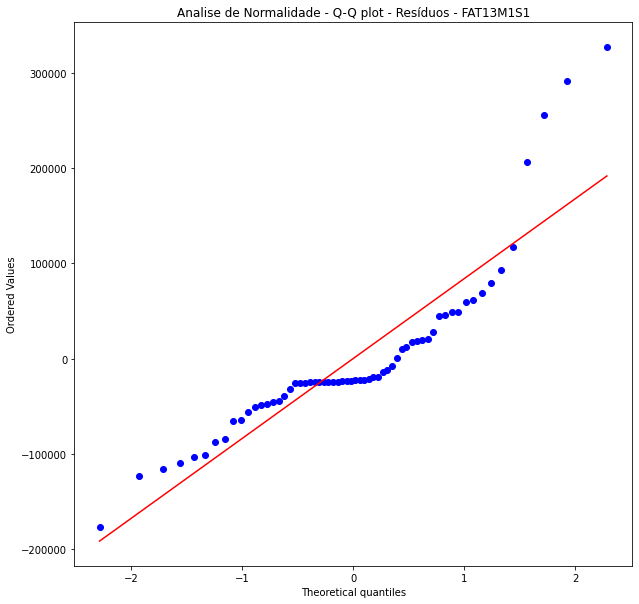

In [1805]:
# utilizando o grafico qq-plot para ver se os RESIDUOS possuem uma distribuição normal
stats.probplot(residuos, dist='norm', plot=plt)
plt.title('Analise de Normalidade - Q-Q plot - Resíduos - ' + sIT_CODIGO)
plt.show()


In [1806]:
# Como os pontos azuis estao bem proximos da reta vermelha, concluimos que se trata de uma distribuicao normal

In [1807]:
# Analise da HOMOCEDASTICIDADE dos residuos
# como estao distribuidos os residuos, verificando se a distribuição é HOMOGENEA ou NÃO.
# O ideal é que os residuos tenham uma distribuição CONSTANTE para que passe no teste de HOMOCEDASTICIDADE
# caso não passe, signifca que temos residuos HETEROCEDASTICIDADE
# esta analise pode ser realizada via grafico abaixo

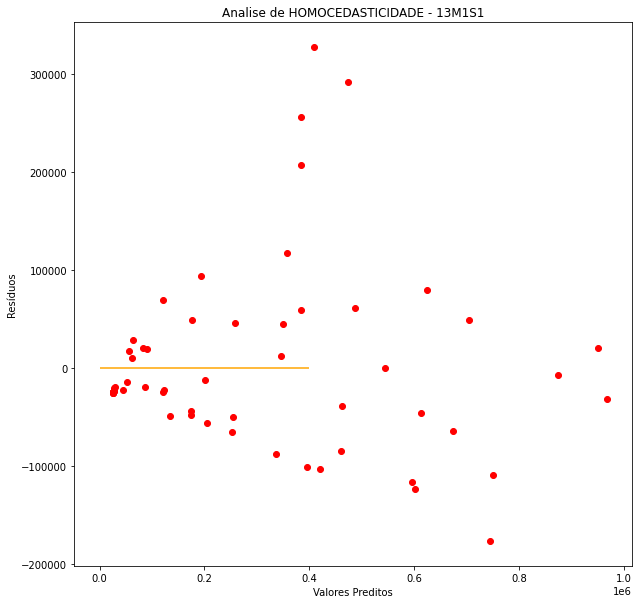

In [1808]:
plt.scatter(y=residuos, x=regressao.predict(), color='red')
plt.hlines(y=0, xmin=0, xmax=400000, color='orange')
plt.title('Analise de HOMOCEDASTICIDADE - ' + sIT_CODIGO[-6:])
plt.ylabel('Resíduos')
plt.xlabel('Valores Preditos')
plt.show()

In [1809]:
# a linha LARANJA é a linha de referencia y=0 e analisamos como os pontos estao distribuidos
# passaria no teste da HOMOCEDASTICIDADE, caso os pontos vermelhos formassem um retangulo perfeito com a linha LARANJA no centro
# por este grafico não podemos confirmar que passou pelo teste da HOMOCEDASTICIDADE

In [1810]:
# desta forma podemos tentar atraves de outro teste, chamado de Breusch-Pagan

# Teste Breusch-Pagan (Homocedasticidade ou heterocedasticidade)
# Ho = existe homocedasticidade : p > 0.05
# Ha = não existe homocedasticidade : p <= 0.05

In [1811]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

In [1812]:
estatistica, p, f, fp = sms.het_breuschpagan(regressao.resid, regressao.model.exog)
print('Estatística de teste Breusch-Pagan : {}'.format(estatistica))
print('p-valor: {}'.format(p))
print('f-valor: {}'.format(f))
print('f_p-valor: {}'.format(fp))

Estatística de teste Breusch-Pagan : 3.6420049290232814
p-valor: 0.05633905065613974
f-valor: 3.7444791493543614
f_p-valor: 0.057699975412221556


In [1813]:
# como p-valor = 0.39986615934062664, ou seja, > 0.05, então é aceito a hipotese nula, ou seja, trata-se de uma distribuicao normal dos residuos e os
# residuos apresentam uma distribuição CONSTANTE

In [1814]:
# Para os casos em que o p-valor for inferior a 0,05 significa que a variancia dos erros apresenta heterocedasticidade, 
# desta forma podemos aplicar o teste de Bartlett para confirmar a informação

In [1815]:
import scipy.stats as stats
  
# data separado em 12 grupos representando as vendas por mes
data = [df_mes[df_mes['MES'] == 1]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 2]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 3]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 4]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 5]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 6]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 7]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 8]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 9]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 10]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 11]['VL_VENDA_TOT'],
        df_mes[df_mes['MES'] == 12]['VL_VENDA_TOT']]
 
# performing Bartlett's test
test_statistic, p_value = stats.bartlett(data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],data[8],data[9],data[10],data[11])

print(test_statistic, p_value)

14.217442847956354 0.22119416728812694


In [1816]:
######################## Test T ###########################################################################################
# Porém o produto 1-B301 rejeitou a hipótese nula, desta forma é aplicado o Teste T, trata-se de um teste paramétrico 
# usado para testar uma diferença estatisticamente significativa nas médias entre dois grupos. 
# Tal como acontece com todos os testes paramétricos, existem certas condições que precisam ser 
# atendidas para que os resultados do teste sejam considerados confiáveis.


In [1817]:
#!pip install researchpy
import researchpy as rp

#print(df_mes.info())

#INDEPDENT T-TEST USING RESEARCHPY

# The method returns 2 data frames, one that contains the summary statistical information and the other that contains the
# statistical test information. If the returned data frames are not stored as a Python object then the output will be less 
# clean than it can be since it will be displayed as a tuple - see below


In [1818]:
summary, results = rp.ttest(group1= df_mes['VL_VENDA_TOT'][df_mes['MES'] <= 6], group1_name= "Semestre-1",
                            group2= df_mes['VL_VENDA_TOT'][df_mes['MES'] >= 7], group2_name= "Semestre-2")
print(summary)

     Variable     N           Mean             SD            SE      95% Conf.       Interval
0  Semestre-1  30.0  281594.599667  273475.062169  49929.486822  179477.333202  383711.866131
1  Semestre-2  32.0  286716.940937  289648.719582  51203.143445  182287.441384  391146.440491
2    combined  62.0  284238.388710  279638.635500  35514.142223  213223.472352  355253.305068


In [1819]:
print(results)

                        Independent t-test    results
0  Difference (Semestre-1 - Semestre-2) =  -5122.3413
1                    Degrees of freedom =     60.0000
2                                     t =     -0.0715
3                 Two side test p value =      0.9432
4                Difference < 0 p value =      0.4716
5                Difference > 0 p value =      0.5284
6                             Cohen's d =     -0.0182
7                             Hedge's g =     -0.0179
8                         Glass's delta =     -0.0187
9                           Pearson's r =      0.0092


In [1820]:
# Realizando o teste T com a lib scipy.stats = INDEPDENT T-TEST USING SCIPY.STATS
# Este método realiza o teste t de amostra independente e retorna apenas a estatística do teste t e seu valor p associado. 


In [1821]:
import scipy.stats as stats

In [1822]:
stats.ttest_ind(df_mes['VL_VENDA_TOT'][df_mes['MES'] <= 6],
                df_mes['VL_VENDA_TOT'][df_mes['MES'] >= 7])

Ttest_indResult(statistic=-0.07148917909626218, pvalue=0.9432462001231625)

In [1823]:
stats.levene(df_mes['VL_VENDA_TOT'][df_mes['MES'] <= 6],
                df_mes['VL_VENDA_TOT'][df_mes['MES'] >= 7],
             center= 'mean')

LeveneResult(statistic=0.25500590032493675, pvalue=0.6154219597091357)

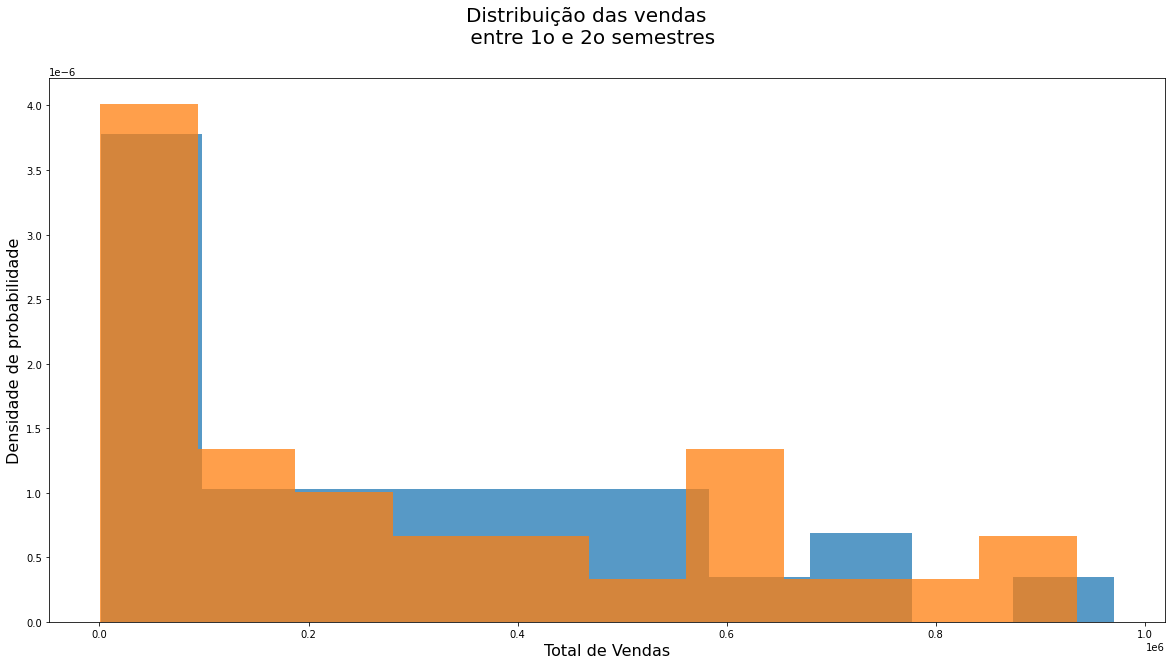

In [1824]:
fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)


p_vendas_1 = plt.hist(df_mes['VL_VENDA_TOT'][df_mes['MES'] <= 6], label= "Semestre-1",
                     density= True,
                     alpha=0.75)
p_vendas_2 = plt.hist(df_mes['VL_VENDA_TOT'][df_mes['MES'] >= 7], label= "Semestre-2",
                       density= True,
                       alpha=0.75)

plt.suptitle("Distribuição das vendas \n entre 1o e 2o semestres", fontsize= 20)
plt.xlabel("Total de Vendas", fontsize= 16)
plt.ylabel("Densidade de probabilidade", fontsize= 16)

#plt.text(0.5, 0.5, "xxxxxxxxxxxxxx11")
#plt.text(133, .025,f"$\mu= {df_mes['VL_VENDA_TOT'][df_mes['MES'] <= 6].mean(): .1f}, \ \sigma= {df_mes['VL_VENDA_TOT'][df_mes['MES'] <= 6].std(): .1f}$")
#plt.text(160, .025,f"$\mu= {df_mes['VL_VENDA_TOT'][df_mes['MES'] >= 7].mean(): .1f}, \ \sigma= {df_mes['VL_VENDA_TOT'][df_mes['MES'] >= 7].std(): .1f}$")
plt.show()

In [1825]:
print('Verificar o OUTLIER dos residuos #################################################################################################### ')
# neste cenario temos que ter o valor minimo e maximo compreendido entre -3 e 3.

Verificar o OUTLIER dos residuos #################################################################################################### 


In [1826]:
outliers = regressao.outlier_test()

print(outliers.max())
# student_resid    2.936479     -> esta dentro do limite ou seja até 3
# unadj_p          0.984653
# bonf(p)          1.000000

print(outliers.min())
# student_resid   -2.130005     -> esta dentro do limite ou seja até -3
# unadj_p          0.009221
# bonf(p)          0.184412

# Com isso concluimos que o modelo foi aprovado

student_resid    4.077895
unadj_p          0.999139
bonf(p)          1.000000
dtype: float64
student_resid   -2.061071
unadj_p          0.000138
bonf(p)          0.008557
dtype: float64


In [1827]:
# obtendo as informações do modelo
print(regressao.summary())
#                             OLS Regression Results
# ==============================================================================
# Dep. Variable:           VL_VENDA_TOT   R-squared:                       0.946
# Model:                            OLS   Adj. R-squared:                  0.943
# Method:                 Least Squares   F-statistic:                     318.1
# Date:                Sun, 30 Jan 2022   Prob (F-statistic):           6.90e-13
# Time:                        06:32:19   Log-Likelihood:                -231.81
# No. Observations:                  20   AIC:                             467.6
# Df Residuals:                      18   BIC:                             469.6
# Df Model:                           1
# Covariance Type:            nonrobust
# ==============================================================================
#                  coef    std err          t      P>|t|      [0.025      0.975]
# ------------------------------------------------------------------------------
# Intercept   2.853e+04   9488.467      3.007      0.008    8595.819    4.85e+04        --> coeficiente linear
# QUANTIDADE  1.139e+04    638.408     17.834      0.000       1e+04    1.27e+04        --> coeficiente angular
# ==============================================================================
# Omnibus:                        4.088   Durbin-Watson:                   1.440
# Prob(Omnibus):                  0.130   Jarque-Bera (JB):                2.431
# Skew:                           0.837   Prob(JB):                        0.297
# Kurtosis:                       3.340   Cond. No.                         22.9
# ==============================================================================

                            OLS Regression Results                            
Dep. Variable:           VL_VENDA_TOT   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     515.6
Date:                Sun, 20 Nov 2022   Prob (F-statistic):           3.76e-31
Time:                        08:44:47   Log-Likelihood:                -794.93
No. Observations:                  62   AIC:                             1594.
Df Residuals:                      60   BIC:                             1598.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.545e+04   1.62e+04      1.568      0.1

In [1828]:
# obtendo as informações do modelo
print(regressao.summary())

                            OLS Regression Results                            
Dep. Variable:           VL_VENDA_TOT   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     515.6
Date:                Sun, 20 Nov 2022   Prob (F-statistic):           3.76e-31
Time:                        08:44:47   Log-Likelihood:                -794.93
No. Observations:                  62   AIC:                             1594.
Df Residuals:                      60   BIC:                             1598.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.545e+04   1.62e+04      1.568      0.1

In [1829]:
# Observe que o coeficiente angular QUANTIDADE = p>|t| = 0.000 ou seja, eh menor que 0,05 sendo assim o coeficiente é valido

# Alem disso, o ajuste do modelo foi muito bom "Adj. R-squared:                  0.943" 94,3%

# Agora conseguimos montar a equacao da regressa linear

# Variavel dependente = VL_VENDA_TOT

# EQUACAO => VL_VENDA_TOT = INTERCEPT + QUANTIDADE x [INDICE DA QUANTIDADE]

# VL_VENDA_TOT = 2.853e+04 +  1.139e+04 X  [INDICE DA QUANTIDADE]
# VL_VENDA_TOT = 28530.34 +  11385.53 X  [INDICE DA QUANTIDADE]

# Previsao de faturamento de 16 unidades
# VL_VENDA_TOT = 28530.34 +  11385.53 X  [16]
# VL_VENDA_TOT = 210698,82 (verificar IDX 21 do dataframe para validar)

In [1830]:
# Para obter os coeficientes mencionados acima INTERCEPT  podemos utilizar o comando abaixo:
coefs = pd.DataFrame(regressao.params)
coefs.columns = ['Coeficientes']
print(coefs)

#            Coeficientes
# Intercept   29460.971652
# QUANTIDADE  11385.918790
# IPCA         -602.422986

    # Previsao de faturamento de 16 unidades
    # VL_VENDA_TOT = 29460.97 +  (11385.92 X  [16]) + (-602.42 x [0,96])
    # VL_VENDA_TOT = 29460.97 +  182174,72 - 9638,72)
    # VL_VENDA_TOT = 211057,40

    # Previsao de faturamento de 2 unidades
    # VL_VENDA_TOT = 29460.97 +  (11385.92 X  [2]) + (-602.42 x [0,56])
    # VL_VENDA_TOT = 29460.97 +  22771,84 - 337,35)
    # VL_VENDA_TOT = 51895,45

    # Previsao de faturamento de 1 unidades
    # VL_VENDA_TOT = 29460.97 +  (11385.92 X  [1]) + (-602.42 x [0,22])
    # VL_VENDA_TOT = 29460.97 +  11385.92 - 132,53)
    # VL_VENDA_TOT = 40714,36

            Coeficientes
Intercept   25452.770309
QUANTIDADE    597.256862


In [1831]:
print(df_mes)
#      ANO  MES  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM       RESIDUOS
# 0   2017   11           2      47385.61   19463.34     Nov   143.460835       -3915.809088 => (REAL 47385.61 - PREV 51301.41)
# 1   2018    4           1      19156.03    7185.65     Abr   166.587296
# 2   2018    6           2      13629.24   14371.30     Jun    -5.163486
# 3   2018    7           5      83637.08   35928.23     Jul   132.789314
# 4   2018    9          16     256278.26  114970.36     Set   122.908113
# 5   2019    8           7     119130.44   70037.02     Ago    70.096386
# 6   2019   10          12     231271.02  120063.46     Out    92.623984       66114.252082
# 7   2019   12          13     214839.13  130068.74     Dez    65.173531
# 9   2020    7          38     420742.95  247117.64     Jul    70.260185
# 10  2020   10          25     299003.72  192750.85     Out    55.124462
# 11  2020   11           3      50623.82   26090.46     Nov    94.031918
# 12  2020   12           9     128101.19   78271.32     Dez    63.662999
# 13  2021    2           5      78209.16   36356.05     Fev   115.120069
# 15  2021    5           4      69565.22   36206.50     Mai    92.134617
# 16  2021    6          25     312658.48  168511.90     Jun    85.540891
# 18  2021    8          22     270704.05  162610.57     Ago    66.473834
# 19  2021    9          10     119640.77   73876.87     Set    61.946182
# 20  2021   10          10     163024.79   80196.11     Out   103.282665
# 21  2021   11          16     227006.48  121990.20     Nov    86.085833       -16307,10 => (REAL 227006.48  - PREV 210698,82)
# 22  2021   12           1      19130.43    7895.89     Dez   142.283390


     ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0   2006    5  0.10           1       1095.65     504.62     Mai    53.943321    1095.650000
2   2006    7  0.19           2       3443.48    1034.84     Jul    69.947843    1721.740000
3   2006    8  0.05           1        869.57     447.47     Ago    48.541233     869.570000
4   2006    9  0.21          50      72655.44   22373.25     Set    69.206366    1453.108800
5   2006   10  0.33          63      91265.97   31300.65     Out    65.703920    1448.666190
6   2006   11  0.31           4       6846.26    1987.34     Nov    70.971888    1711.565000
7   2007    1  0.44           1       1869.57     496.84     Jan    73.424905    1869.570000
8   2007    2  0.44           2       2791.30     964.88     Fev    65.432594    1395.650000
9   2007    3  0.37         160     190310.96   77190.30     Mar    59.439908    1189.443500
10  2007    4  0.25          60      71366.61   28375.08     Abr    60

In [1832]:
print(regressao.predict())
# [ 51301.41908754  39915.88420448  51301.41908754  85458.02373672
#  210698.90745038 108229.09350284 165156.76791814 176542.3028012
#  461180.6748777  313168.72139792  62686.9539706  131000.16326896
#   85458.02373672  74072.48885366 313168.72139792 279012.11674874
#  142385.69815202 142385.69815202 210698.90745038  39915.88420448]

[ 26050.02717099  26647.284033    26050.02717099  55315.61340913
  63079.95261517  27841.797757    26050.02717099  26647.284033
 121013.86822943  61288.18202916  26050.02717099 384404.14437266
  26050.02717099  30230.82520501  28439.054619    82192.17219925
  28439.054619    89956.51140529 134153.5191935  258980.20335208
 357527.58558253 473395.41681107 408891.67571477 383806.88751066
  26050.02717099 193879.20539377 176558.75639569  52329.32909912
 385001.40123466 349165.9895145  200449.0308758  345582.44834248
  86970.22709528 486535.06777513 625098.65975978 704533.82240615
 543871.7265274  673476.465582   174766.98580968 253007.63473205
 204629.82890982 600611.12841766 595833.07352164 460853.02270901
 420239.55609283 395752.02475071 337220.85227444 744550.03216033
 751119.85764236 174766.98580968 254202.14845605 951200.90641329
 461450.27957102 121611.12509144 122805.63881544 967326.84168737
  43967.73303108 873557.51435293 613153.52251972  26050.02717099
  26050.02717099  26050.027

In [1833]:
# a funcao predict() retorna o valor calculado para variavel dependente (VL_VENDA_TOT) em cada linha do dataset
# Exemplo IDX=0 do dataset, a variavel VL_VENDA_TOT = 47385.61 , já o modelo calculou 51301.41 (RESIDUO = -3915.809088)

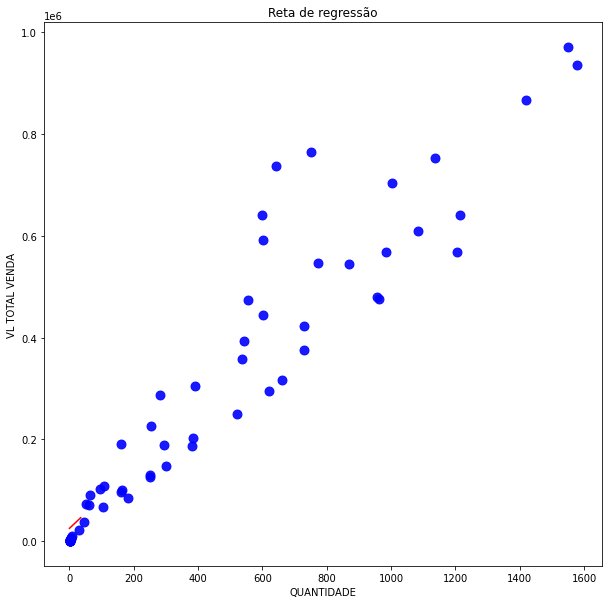

In [1834]:
# Aplicando a equacao no grafico de disperssão para avaliar o ajuste de reta na distriuibicao das previsoes
plt.scatter(y=df_mes.VL_VENDA_TOT, x=df_mes.QUANTIDADE, color='blue', s=80, alpha=0.9)
X_plot = np.linspace(0, 35)
plt.plot(X_plot, X_plot * regressao.params[1] + regressao.params[0], color='r')
plt.title('Reta de regressão')
plt.ylabel('VL TOTAL VENDA')
plt.xlabel('QUANTIDADE')
plt.show()


In [1835]:
# Regressão linear utilizando o SKLEARN #####################################################################################################################

In [1836]:
print(df_mes.head())

    ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0  2006    5  0.10           1       1095.65     504.62     Mai    53.943321     1095.65000
2  2006    7  0.19           2       3443.48    1034.84     Jul    69.947843     1721.74000
3  2006    8  0.05           1        869.57     447.47     Ago    48.541233      869.57000
4  2006    9  0.21          50      72655.44   22373.25     Set    69.206366     1453.10880
5  2006   10  0.33          63      91265.97   31300.65     Out    65.703920     1448.66619


In [1837]:
x = df_mes.iloc[:, 3].values  # obter todas as linhas (:), e a coluna (2) (QUANTIDADE)  (VARIAVEL INDEPENDENTE)
y = df_mes.iloc[:, 4].values  # obter todas as linhas (:), e a coluna (3) (VL_VENDA_TOT)  (VARIAVEL DEPENDENTE)

In [1838]:
# identificar a correlacao
correlacao2 = np.corrcoef(x, y)
print(correlacao2)
# [[1.        0.9728506]
#  [0.9728506 1.       ]]

[[1.         0.94644637]
 [0.94644637 1.        ]]


In [1839]:
# Esta em formato de um vetor apenas
print(x)
# [ 2  1  2  5 16  7 12 13 38 25  3  9  5  4 25 22 10 10 16  1]

[   1    2    1   50   63    4    1    2  160   60    1  601    1    8
    5   95    5  108  182  391  556  750  642  600    1  282  253   45
  602  542  293  536  103  772 1004 1137  868 1085  250  381  300  963
  955  729  661  620  522 1204 1215  250  383 1550  730  161  163 1577
   31 1420  984    1    1    1]


In [1840]:
x = x.reshape(-1, 1)  # transformando em matriz

In [1841]:
print('transformando em matriz')
print(x)
# [[ 2]
#  [ 1]
#  [ 2]
#  [ 5]
#  [16] .....

transformando em matriz
[[   1]
 [   2]
 [   1]
 [  50]
 [  63]
 [   4]
 [   1]
 [   2]
 [ 160]
 [  60]
 [   1]
 [ 601]
 [   1]
 [   8]
 [   5]
 [  95]
 [   5]
 [ 108]
 [ 182]
 [ 391]
 [ 556]
 [ 750]
 [ 642]
 [ 600]
 [   1]
 [ 282]
 [ 253]
 [  45]
 [ 602]
 [ 542]
 [ 293]
 [ 536]
 [ 103]
 [ 772]
 [1004]
 [1137]
 [ 868]
 [1085]
 [ 250]
 [ 381]
 [ 300]
 [ 963]
 [ 955]
 [ 729]
 [ 661]
 [ 620]
 [ 522]
 [1204]
 [1215]
 [ 250]
 [ 383]
 [1550]
 [ 730]
 [ 161]
 [ 163]
 [1577]
 [  31]
 [1420]
 [ 984]
 [   1]
 [   1]
 [   1]]


In [1842]:
!pip install sklearn

You should consider upgrading via the 'c:\python\projects\cpsoracle02\scripts\python.exe -m pip install --upgrade pip' command.


In [1843]:
from sklearn.linear_model import LinearRegression

In [1844]:
regressao2 = LinearRegression()
regressao2.fit(x, y)

LinearRegression()

In [1845]:
print(regressao2.intercept_)
# 28530.349321424743           ==> mesmo valor apresentado no modulo statsmodel

print(regressao2.coef_)
# 11385.53488306                  ==> mesmo valor apresentado no modulo statsmodel

25452.770308990846
[597.256862]


In [1846]:
# coeficiente de determinacao
print(regressao2.score(x, y))
# 0.9464382985779555            ==> mesmo valor apresentado no modulo statsmodel

0.895760734655219


In [1847]:
# EQUACAO: VL_VENDA_TOT = 28530.34 +  11385.53 X  [INDICE DA QUANTIDADE]

In [1848]:
# R^2 AJUSTADO = 0.946

In [1849]:
print(df_mes.head(20))

     ANO  MES  IPCA  QUANTIDADE  VL_VENDA_TOT  CMV_TOTAL MES_EXT  PERC_MARGEM  VL_VENDA_UNIT
0   2006    5  0.10           1       1095.65     504.62     Mai    53.943321    1095.650000
2   2006    7  0.19           2       3443.48    1034.84     Jul    69.947843    1721.740000
3   2006    8  0.05           1        869.57     447.47     Ago    48.541233     869.570000
4   2006    9  0.21          50      72655.44   22373.25     Set    69.206366    1453.108800
5   2006   10  0.33          63      91265.97   31300.65     Out    65.703920    1448.666190
6   2006   11  0.31           4       6846.26    1987.34     Nov    70.971888    1711.565000
7   2007    1  0.44           1       1869.57     496.84     Jan    73.424905    1869.570000
8   2007    2  0.44           2       2791.30     964.88     Fev    65.432594    1395.650000
9   2007    3  0.37         160     190310.96   77190.30     Mar    59.439908    1189.443500
10  2007    4  0.25          60      71366.61   28375.08     Abr    60

In [1850]:
previsoes = regressao2.predict(x)
print(previsoes)

[ 26050.02717099  26647.284033    26050.02717099  55315.61340913
  63079.95261517  27841.797757    26050.02717099  26647.284033
 121013.86822943  61288.18202916  26050.02717099 384404.14437266
  26050.02717099  30230.82520501  28439.054619    82192.17219925
  28439.054619    89956.51140529 134153.5191935  258980.20335208
 357527.58558253 473395.41681107 408891.67571477 383806.88751066
  26050.02717099 193879.20539377 176558.75639569  52329.32909912
 385001.40123466 349165.9895145  200449.0308758  345582.44834248
  86970.22709528 486535.06777513 625098.65975978 704533.82240615
 543871.7265274  673476.465582   174766.98580968 253007.63473205
 204629.82890982 600611.12841766 595833.07352164 460853.02270901
 420239.55609283 395752.02475071 337220.85227444 744550.03216033
 751119.85764236 174766.98580968 254202.14845605 951200.90641329
 461450.27957102 121611.12509144 122805.63881544 967326.84168737
  43967.73303108 873557.51435293 613153.52251972  26050.02717099
  26050.02717099  26050.027

In [1851]:
# mesmas previsoes do statsmodel

In [1852]:
# se precisar fazer uma previsao diferente aplicando a formula.
previsao = regressao2.predict([[15]])
print('O faturamento total deverá ser de {}'.format(previsao))
# O faturamento total deverá ser de [210698.90745038]

O faturamento total deverá ser de [34411.62323903]


In [1875]:
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################### COMPARANDO OS MODELOS ####################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################

In [1876]:
# Criandos dataframes para o eixo X e Y
# no eixo X deve-se eliminar a variavel dependente VL_VENDA_TOT, VL_VENDA_UNIT, variavel do tipo string MES_EXT
# Nos testes realizados, ficou evidenciado que ao excluir as variaveis ANO e MES, houve melhora no R2

y = df_mes[["VL_VENDA_TOT"]]
x = df_mes.drop(["ANO", "MES", "MES_EXT", "VL_VENDA_TOT", "VL_VENDA_UNIT"], axis=1)
print(x)
print(y)

SEED = 746

# O dataset sera separado em 70% para treinamento e 30% para teste, para avaliar o modelo test_size=0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED)

    IPCA  QUANTIDADE  CMV_TOTAL  PERC_MARGEM
0   0.10           1     504.62    53.943321
2   0.19           2    1034.84    69.947843
3   0.05           1     447.47    48.541233
4   0.21          50   22373.25    69.206366
5   0.33          63   31300.65    65.703920
6   0.31           4    1987.34    70.971888
7   0.44           1     496.84    73.424905
8   0.44           2     964.88    65.432594
9   0.37         160   77190.30    59.439908
10  0.25          60   28375.08    60.240398
11  0.28           1     472.92    72.252178
12  0.18         601  248315.65    57.988884
13  0.38           1     413.17    68.323686
14  0.54           8    3305.37    68.379711
15  0.49           5    2065.86    66.120891
17  0.55          95   34192.40    66.718142
18  0.79           5    1818.70    61.457196
19  0.74         108   36249.12    66.710454
20  0.53         182   61088.30    28.484965
21  0.28         391  121253.01    60.230521
22  0.26         556  182851.72    61.484390
24  0.36  

TOTAL DE VENDA NO PERIODO 17622780.099999998
QTD   DE VENDA NO PERIODO 26864
Valor Unitario MEDIO de venda 655.9998548243001
    QUANTIDADE  VL_VENDA_TOT  PREV_VENDA_MEDIA     VL_RESIDUO
4           50      72655.44      3.279999e+04  -39855.447259
7            1       1869.57      6.559999e+02   -1213.570145
10          60      71366.61      3.935999e+04  -32006.618711
11           1       1704.35      6.559999e+02   -1048.350145
15           5       6097.74      3.279999e+03   -2817.740726
17          95     102735.85      6.231999e+04  -40415.863792
19         108     108890.40      7.084798e+04  -38042.415679
20         182      85420.22      1.193920e+05   33971.753578
28           1       1186.70      6.559999e+02    -530.700145
31          45      37680.68      2.951999e+04   -8160.686533
34         542     394171.58      3.555519e+05  -38619.658685
36         536     358162.34      3.516159e+05   -6546.417814
50         963     476770.57      6.317279e+05  154957.290196
55     

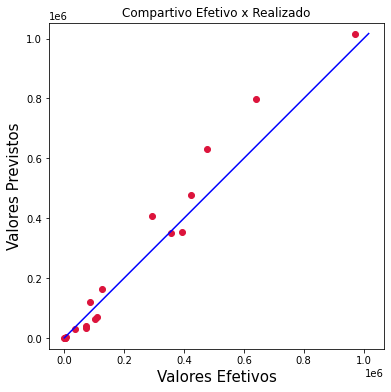

[[    655]
 [  39359]
 [  62319]
 [ 163999]
 [    655]
 [  70847]
 [ 406719]
 [   3279]
 [  32799]
 [ 631727]
 [ 478879]
 [ 355551]
 [ 119391]
 [ 351615]
 [    655]
 [1016799]
 [  29519]
 [ 797039]
 [    655]]
R2 Media Simples : 0.9403611230635474


In [1877]:
# CALCULANDO PELA MEDIA SEM UTILIZAR ALGORITMO


df_media = df_mes[['QUANTIDADE', 'VL_VENDA_TOT']].copy()
#print(df_media)


df_media['PREV_VENDA_MEDIA'] = (df_media['VL_VENDA_TOT'].sum() / df_media['QUANTIDADE'].sum()) * df_media['QUANTIDADE']
print('TOTAL DE VENDA NO PERIODO {}'.format(df_media['VL_VENDA_TOT'].sum()))
print('QTD   DE VENDA NO PERIODO {}'.format(df_media['QUANTIDADE'].sum()))
print('Valor Unitario MEDIO de venda {}'.format(df_media['VL_VENDA_TOT'].sum() / df_media['QUANTIDADE'].sum()))

df_media['VL_RESIDUO'] = df_media['PREV_VENDA_MEDIA'] - df_media['VL_VENDA_TOT']


# Manter no dataframe df_media, somente os INDEX contidos no y_test
for index,v in df_media['PREV_VENDA_MEDIA'].iteritems():
    if index not in y_test.index:
        df_media.drop(index, inplace=True)

print(df_media.sort_index())
df_media.sort_index().to_excel(r'c:\windows\temp\residuos_media-' + sIT_CODIGO + '.xlsx', index = True)

# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_media['PREV_VENDA_MEDIA']))
true_value = tuple(list(df_media['VL_VENDA_TOT']))

plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Compartivo Efetivo x Realizado')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(False)
plt.show()



# criando array MEDIA com base no dataset y_test
# print(df_media['VL_VENDA_TOT'][13],df_media['PREV_VENDA_MEDIA'][13],df_media['RESIDUO'][13])
previsao_media=y_test.copy()[[]] #copiando os indices do df y_test para a previsao_media
previsao_media['PREV_VENDA_MEDIA']=0


# Atribuindo valores de media para o df previsao_media conforme os indices selecionados no y_test
for index,v in df_media['PREV_VENDA_MEDIA'].iteritems():
    if index in previsao_media.index:
        previsao_media['PREV_VENDA_MEDIA'][index]=v

#print(previsao_media)
previsao_media2 = previsao_media.to_numpy()
print(previsao_media2)
print(f'R2 Media Simples : {metrics.r2_score(y_test, previsao_media2)}')



In [1878]:
#!pip install pmdarima

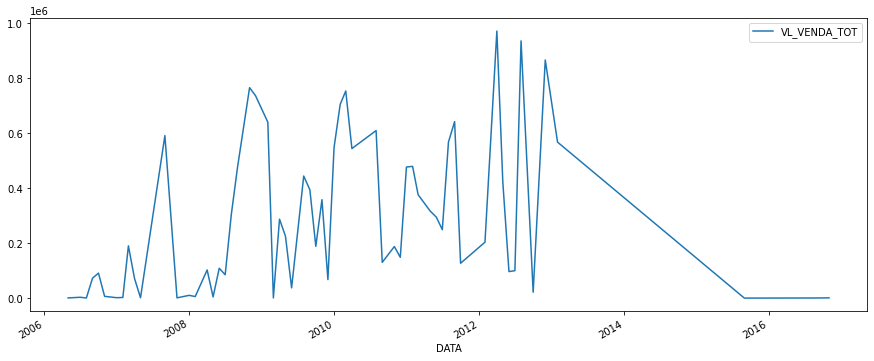

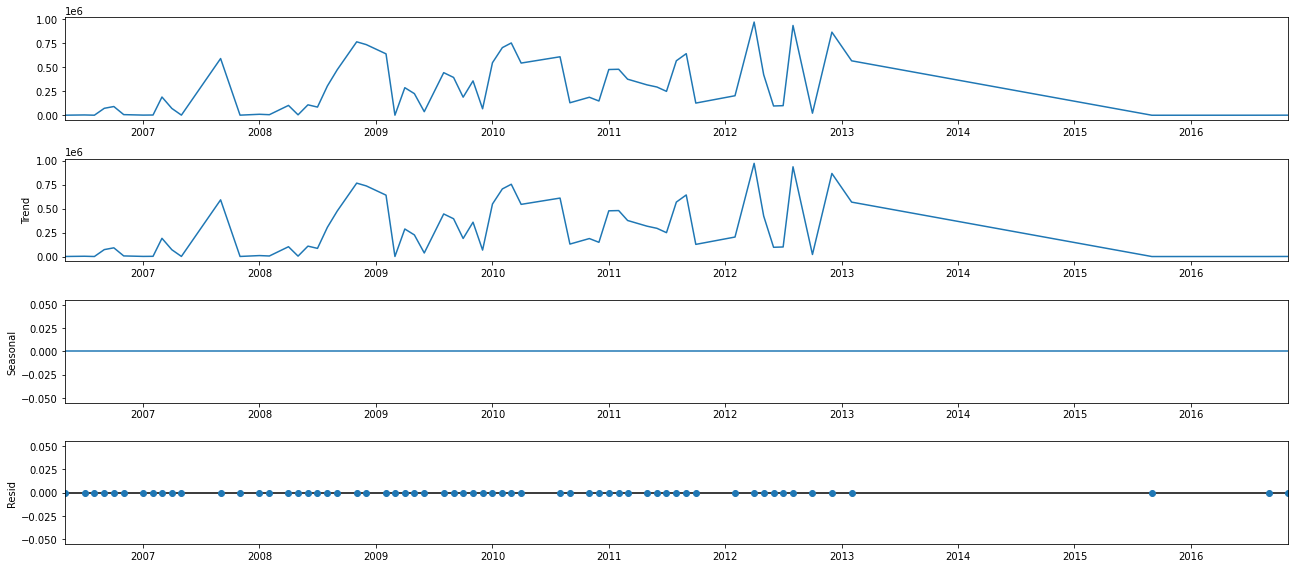

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2130      0.392      0.543      0.587      -0.556       0.982
ma.L1         -0.8942      0.235     -3.803      0.000      -1.355      -0.433
ar.S.L12      -0.0627      0.811     -0.077      0.938      -1.653       1.528
ma.S.L12      -0.5687      0.769     -0.739      0.460      -2.077       0.939
sigma2      1.538e+11   8.28e-12   1.86e+22      0.000    1.54e+11    1.54e+11


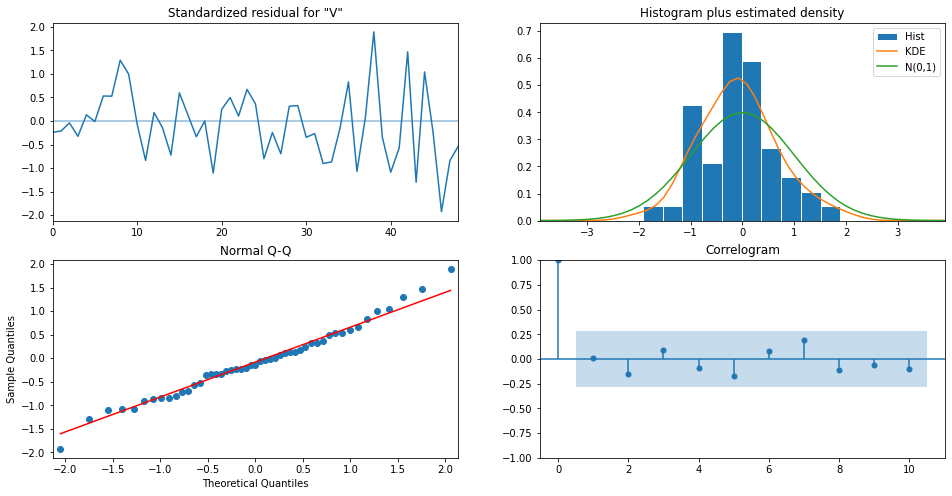

In [1879]:
################################# ARIMA #############################################################################

#https://www.linkedin.com/pulse/previs%C3%A3o-de-vendas-com-an%C3%A1lise-s%C3%A9ries-temporais-everton-s-paula/?originalSubdomain=pt

import statsmodels.api as sm

df = df_mes.drop(["MES_EXT", "IPCA", "QUANTIDADE", "CMV_TOTAL", "PERC_MARGEM" , "VL_VENDA_UNIT"], axis=1) 
df["MES"] = df['MES'].apply(lambda x: '{0:0>2}'.format(x)) 
df["DATA"] = pd.to_datetime(df["ANO"].map(str) + df["MES"] + "01", format='%Y%m%d')

df = df.drop(["ANO", "MES"], axis=1)

df = df.sort_values('DATA') #print(df.isnull().sum())

#Agregar as vendas por data
df = df.groupby('DATA')['VL_VENDA_TOT'].sum().reset_index()

df = df.set_index('DATA') 
df.index

#y = df['VL_VENDA_TOT'].resamples('MS').mean()
y = df['VL_VENDA_TOT'].mean()

#print(df['2018':]) #print(df)
#print(df)

df.plot(figsize=(15,6)) 
plt.show()

from pylab import rcParams 
rcParams['figure.figsize'] = 18, 8 
decomposition = sm.tsa.seasonal_decompose(df, model='additive', extrapolate_trend='freq', period=1) 
#decomposition = sm.tsa.seasonal_decompose(x=df['DATA'], model='additive', extrapolate_trend='freq', period=2) 
fig = decomposition.plot() 
plt.show()

import itertools 
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q)) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
print('Examples of parameter combinations for Seasonal ARIMA...') 
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1])) 
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))

for param in pdq: 
    for param_seasonal in seasonal_pdq: 
        try: 
            mod = sm.tsa.statespace.SARIMAX(df, 
                                            order=param, 
                                            seasonal_order=param_seasonal, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False) 
            results = mod.fit()
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

#melhor AIC
#ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:102.09495119719587
mod = sm.tsa.statespace.SARIMAX(df, 
                                order=(1, 1, 1), 
                                seasonal_order=(1, 1, 1, 12), 
                                enforce_invertibility=False) 
# enforce_stationarity=False, 
results = mod.fit() 
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validando as Previsoes
#pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
#pred_ci = pred.conf_int()
#ax = df['2016':].plot(label='Observado')
#pred.predicted_mean.plot(ax=ax, label='Previsao proximo periodo', alpha=.7, figsize=(14, 7))
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=0.2)
#ax.set_xlabel('Data')
#ax.set_ylabel('Vendas')
#plt.legend()
#plt.show()

# MSE / RMSE
#y_forecasted = pred.predicted_mean
#y_truth = y['2019-01-01':]
#mse = ((y_forecasted - y_truth) **2).mean()
#print('The Mean Squared Error of our forecast is {}'.format(round(mse, 2)))

# produzindo e visualizando as previsoes

#pred_uc = results.get_forecast(steps=100)
#pred_ci = pred_uc.conf_int()
#ax = df.plot(label='Observado', figsize=(14, 7))
#pred_uc.predicted_mean.plot(ax=ax, label='Previsão')
#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.25)
#ax.set_xlabel('Data')
#ax.set_ylabel('Vendas')
#plt.legend()
#plt.show()



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1411.263, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1416.571, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1413.829, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1409.610, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1417.607, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1414.796, Time=0.03 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1411.426, Time=0.16 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1411.570, Time=0.22 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1413.182, Time=0.06 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1413.769, Time=0.30 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1410.114, Time=0.06 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=1411.930, Time=0.17 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1409.084, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1415.940, Time=0.05 sec
 ARIMA(1,0,0)(1,1,1

<AxesSubplot:>

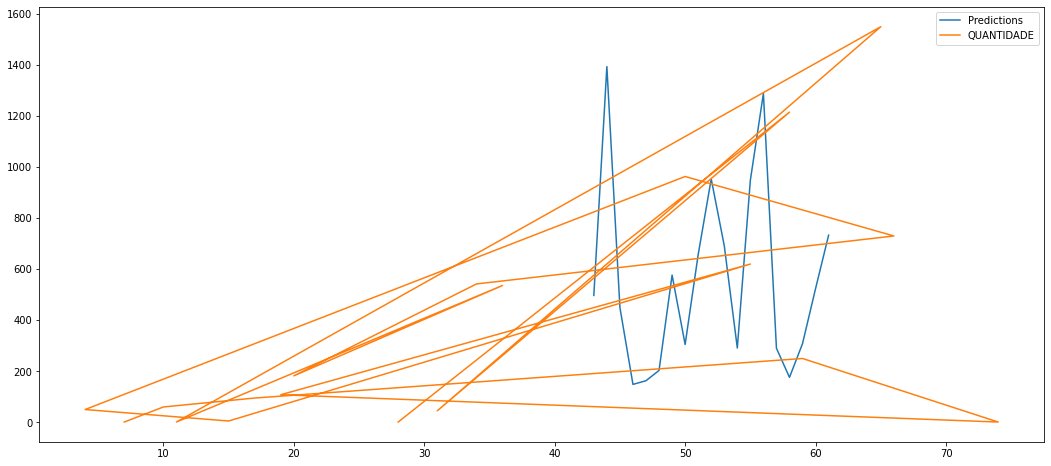

In [1880]:
################################# ARIMA #############################################################################
# https://acervolima.com/python-modelo-arima-para-previsao-de-serie-temporal/

# Modelo ARIMA para previsão de série temporal
# Uma série temporal é definida como uma série de pontos de dados indexados em ordem de tempo. A
# ordem de tempo pode ser diária, mensal ou até anua

# Previsão de série temporal 
# A previsão de série temporal é o processo de usar um modelo estatístico para prever valores futuros de
# uma série temporal com base em resultados anteriores.

# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
  
# Read the AirPassengers dataset
#airline = pd.read_csv('AirPassengers.csv',
#                       index_col ='Month',
#                       parse_dates = True)
  
# Print the first five rows of the dataset
#airline.head()
df_mes.head()
  
# ETS Decomposition
#result = seasonal_decompose(airline['# Passengers'], model ='multiplicative')
#result = seasonal_decompose(df_mes['# QUANTIDADE'], model ='multiplicative')
  
# ETS plot 
#result.plot()


# To install the library
#!pip install pmdarima
  
# Import the library
from pmdarima import auto_arima
  
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
  
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(df_mes['VL_VENDA_TOT'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()


# Split data into train / test sets
train = x_train #airline.iloc[:len(airline)-12]
test = x_test #airline.iloc[len(airline)-12:] # set one year(12 months) for testing
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX
print('summary .....')  
model = SARIMAX(train['QUANTIDADE'], 
                order = (0, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()


start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
test['QUANTIDADE'].plot(legend = True)



The mean squared error (MSE) on test set: 1127659721.2480
R2-Score Gradient Boosting regression: 0.9831418884628942
RMSE Gradient Boosting regression                 : 33580.6450392
    VL_VENDA_TOT  VL_PREVISTO_ALGORITMO  VL_RESIDUO
4       72655.44                  68768    -3887.44
7        1869.57                   3367     1497.43
10      71366.61                  68768    -2598.61
11       1704.35                   3367     1662.65
15       6097.74                   8793     2695.26
17     102735.85                  93419    -9316.85
19     108890.40                  93419   -15471.40
20      85420.22                 100007    14586.78
28       1186.70                   3367     2180.30
31      37680.68                  23599   -14081.68
34     394171.58                 412668    18496.42
36     358162.34                 340431   -17731.34
50     476770.57                 562909    86138.43
55     294453.82                 339743    45289.18
58     641882.85                 60697

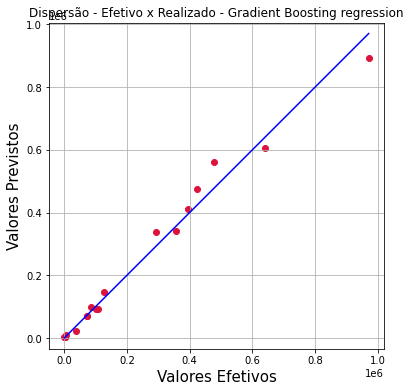

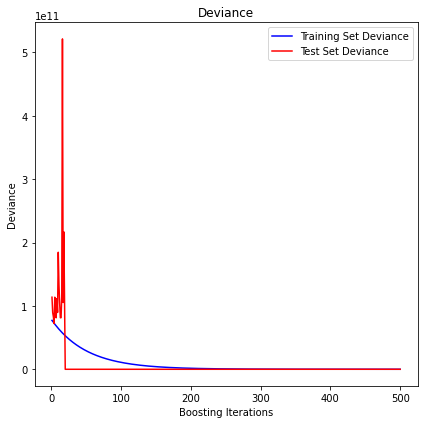

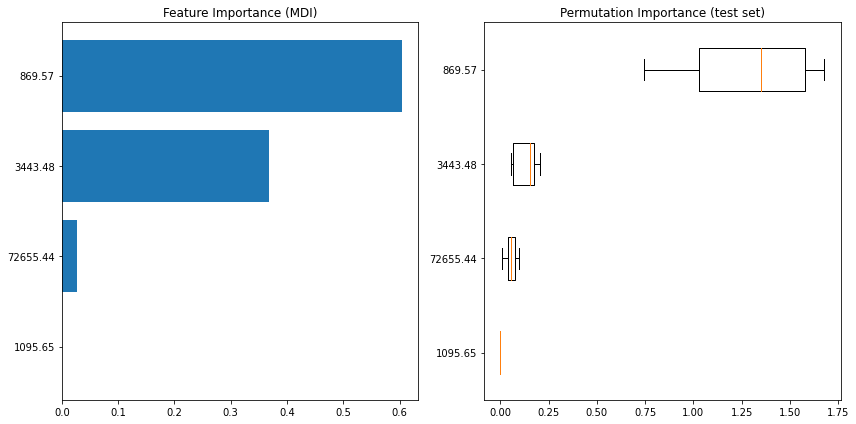

In [1881]:
# Gradient Boosting regression -------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the data

# Data preprocessing
# Next, we will split our dataset to use 70% for training and leave the rest for testing. (as above train_test_split )
# We will also set the regression model parameters. You can play with these parameters to see how the results change.

# n_estimators : the number of boosting stages that will be performed. Later, we will plot deviance against boosting iterations.
# max_depth : limits the number of nodes in the tree. The best value depends on the interaction of the input variables.
# min_samples_split : the minimum number of samples required to split an internal node.
# learning_rate : how much the contribution of each tree will shrink.
# loss : loss function to optimize. The least squares function is used in this case however, there are many other options (see GradientBoostingRegressor ).

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

# Fit regression model
# Now we will initiate the gradient boosting regressors and fit it with our training data. 
# Let’s also look and the mean squared error on the test data.

# Instanciar
modelo_GBR = ensemble.GradientBoostingRegressor(**params)

# Treinar
modelo_GBR.fit(x_train, y_train)

mse = mean_squared_error(y_test, modelo_GBR.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

# Predicao
previsao_GBR = modelo_GBR.predict(x_test)

# Vamos usar o R² -> diz o % que o nosso modelo consegue explicar o que acontece
# verificar acuracia do modelo
print(f'R2-Score Gradient Boosting regression: {metrics.r2_score(y_test, previsao_GBR)}')

# RMSE
rmse = metrics.mean_squared_error(y_test, previsao_GBR, squared=False)
print(f'RMSE Gradient Boosting regression                 : {rmse:.7f}')


# Copiando dataframe para outro
df_result=y_test.copy()

# adicionar coluna ao dataframe df_result
df_result['VL_PREVISTO_ALGORITMO']=0

j = 0
for index,v in y_test['VL_VENDA_TOT'].iteritems():
    #print('y_test index-> {} , y_test VL_VENDA_TOT -> {} , predicao {} '.format(index,v, previsao_regressaolinear[j]))
    if index in df_result.index:
        df_result['VL_PREVISTO_ALGORITMO'][index]=previsao_GBR[j]
    j+=1

# adicionar coluna ao dataframe df_result subtraindo VL_VENDA_TOT, VL_PREVISTO_ALGORITMO     
df_result['VL_RESIDUO']=df_result['VL_PREVISTO_ALGORITMO']-df_result['VL_VENDA_TOT']
    
print(df_result.sort_index())    
df_result.sort_index().to_excel(r'c:\windows\temp\residuos_GBR_seed_' + str(SEED) + '_' + sIT_CODIGO + '.xlsx', index = True)

# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_result['VL_PREVISTO_ALGORITMO']))
true_value = tuple(list(df_result['VL_VENDA_TOT']))

plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Dispersão - Efetivo x Realizado - Gradient Boosting regression')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()



############## rascunho 
# Plot training deviance
# Finally, we will visualize the results. To do that we will first compute the test set deviance and 
# then plot it against boosting iterations.

test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
#for i, y_pred in enumerate(modelo_GBR.staged_predict(x_test)):
for i, y_pred in enumerate(modelo_GBR.predict(x_test)):
    test_score[i] = modelo_GBR.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    modelo_GBR.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()


# Plot feature importance
feature_importance = modelo_GBR.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df_mes.VL_VENDA_TOT)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    modelo_GBR, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df_mes.VL_VENDA_TOT)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()



LinearRegression: 0.9859703093106911
********** Parametros funcao linear ********************************
intercept_ -> [-153965.48225052] 
coef_      -> [[ 8.02729600e+03 -3.91061391e+02  3.30271221e+00  2.78994355e+03]] 
    VL_VENDA_TOT  VL_PREVISTO_ALGORITMO  VL_RESIDUO
4       72655.44                  95141    22485.56
7        1869.57                  55667    53797.43
10      71366.61                  86359    14992.39
11       1704.35                  51032    49327.65
15       6097.74                  39309    33211.26
17     102735.85                 112366     9630.15
19     108890.40                 115578     6687.60
20      85420.22                  60344   -25076.22
28       1186.70                  28373    27186.30
31      37680.68                  35104    -2576.68
34     394171.58                 374822   -19349.58
36     358162.34                 329784   -28378.34
50     476770.57                 494531    17760.43
55     294453.82                 288121    -6332.

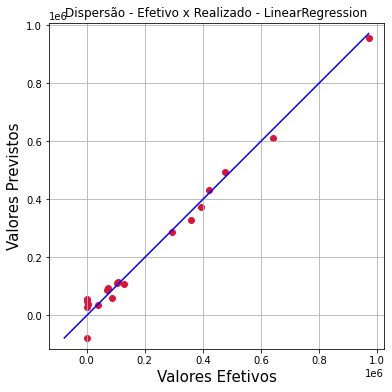

In [1882]:
# REGRESSAO LINEAR ------------------------------------------------------------------------------------------------------------
# Instanciar
modelo_regressaolinear = LinearRegression()

# Treinar
modelo_regressaolinear.fit(x_train, y_train)

# Predicao
previsao_regressaolinear = modelo_regressaolinear.predict(x_test)

# Vamos usar o R² -> diz o % que o nosso modelo consegue explicar o que acontece
# verificar acuracia do modelo
print(f'LinearRegression: {metrics.r2_score(y_test, previsao_regressaolinear)}')

print('********** Parametros funcao linear ********************************')
print('intercept_ -> {} '.format(modelo_regressaolinear.intercept_))
print('coef_      -> {} '.format(modelo_regressaolinear.coef_))


#print(type(previsao_regressaolinear))
#print(previsao_regressaolinear)
#print(type(y_test))
#print(y_test)


#df.plot.scatter(x='QUANTIDADE', y='VL_VENDA_TOT', title='Scatterplot of hours and scores percentages');

# convert numpy array to dataset
#df_previsao_regressaolinear = pd.DataFrame(previsao_regressaolinear, columns = ['VL_TOT_VENDA'])

#new_dataframe = pd.concat([
#    y_test,
#     pd.DataFrame(previsao_regressaolinear, columns = ['VL_TOT_VENDA'])
#], axis=1, ignore_index=True)



# convert numpy array to a tuple
#predicted_value = tuple(previsao_regressaolinear)
#print(previsao_regressaolinear)

#print('##### PREDICTED_VALUE ##################')
#print(type(predicted_value))
#print(predicted_value)

# Convert Pandas Dataframe to a Tuple
#true_value = [tuple(x) for x in y_test.to_numpy()]

#print('##### TRUE_VALUE ##################')
#print(type(true_value))
#print(true_value)

# Copiando dataframe para outro
df_result=y_test.copy()

# adicionar coluna ao dataframe df_result
df_result['VL_PREVISTO_ALGORITMO']=0

j = 0
for index,v in y_test['VL_VENDA_TOT'].iteritems():
    #print('y_test index-> {} , y_test VL_VENDA_TOT -> {} , predicao {} '.format(index,v, previsao_regressaolinear[j]))
    if index in df_result.index:
        df_result['VL_PREVISTO_ALGORITMO'][index]=previsao_regressaolinear[j]
    j+=1

# adicionar coluna ao dataframe df_result subtraindo VL_VENDA_TOT, VL_PREVISTO_ALGORITMO     
df_result['VL_RESIDUO']=df_result['VL_PREVISTO_ALGORITMO']-df_result['VL_VENDA_TOT']
    
print(df_result.sort_index())    
df_result.sort_index().to_excel(r'c:\windows\temp\residuos_LR_seed_' + str(SEED) + '_' + sIT_CODIGO + '.xlsx', index = True)

# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_result['VL_PREVISTO_ALGORITMO']))
true_value = tuple(list(df_result['VL_VENDA_TOT']))

plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Dispersão - Efetivo x Realizado - LinearRegression')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()


ElasticNet: 0.9862211576133479
********** Parametros funcao linear ********************************
intercept_ -> [-149025.74974055] 
coef_      -> [ 650.27824311 -388.95155178    3.29850335 2749.4765072 ] 
<class 'numpy.ndarray'>
    VL_VENDA_TOT  VL_PREVISTO_ALGORITMO  VL_RESIDUO
4       72655.44                  95742    23086.56
7        1869.57                  54390    52520.43
10      71366.61                  87024    15657.39
11       1704.35                  50982    49277.65
15       6097.74                  37960    31862.26
17     102735.85                 110605     7869.15
19     108890.40                 112435     3544.60
20      85420.22                  60348   -25072.22
28       1186.70                  29231    28044.30
31      37680.68                  35329    -2351.68
34     394171.58                 376162   -18009.58
36     358162.34                 329938   -28224.34
50     476770.57                 492498    15727.43
55     294453.82                 290852  

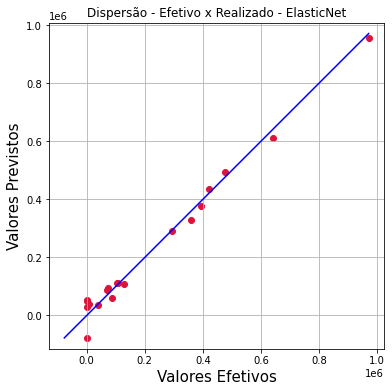

In [1883]:
# ELASTIC NET REGRESSION ----------------------------------------------------------------------------------

#import warnings
#warnings.filterwarnings('ignore')
#warnings.filterwarnings('always')

from sklearn.linear_model import ElasticNet

modelo_el = ElasticNet()

# Treinar
modelo_el.fit(x_train, y_train)

# Predicao
previsao_el = modelo_el.predict(x_test)

print(f'ElasticNet: {metrics.r2_score(y_test, previsao_el)}')

print('********** Parametros funcao linear ********************************')
print('intercept_ -> {} '.format(modelo_el.intercept_))
print('coef_      -> {} '.format(modelo_el.coef_))

print(type(previsao_el))
#print(previsao_el)


# Copiando dataframe para outro
df_result=y_test.copy()

# adicionar coluna ao dataframe df_result
df_result['VL_PREVISTO_ALGORITMO']=0

j = 0
for index,v in y_test['VL_VENDA_TOT'].iteritems():
    #print('y_test index-> {} , y_test VL_VENDA_TOT -> {} , predicao {} '.format(index,v, previsao_regressaolinear[j]))
    if index in df_result.index:
        df_result['VL_PREVISTO_ALGORITMO'][index]=previsao_el[j]
    j+=1

# adicionar coluna ao dataframe df_result subtraindo VL_VENDA_TOT, VL_PREVISTO_ALGORITMO     
df_result['VL_RESIDUO']=df_result['VL_PREVISTO_ALGORITMO']-df_result['VL_VENDA_TOT']
    
print(df_result.sort_index())    
df_result.sort_index().to_excel(r'c:\windows\temp\residuos_ELASTIC_seed_' + str(SEED) + '_' + sIT_CODIGO + '.xlsx', index = True)

# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_result['VL_PREVISTO_ALGORITMO']))
true_value = tuple(list(df_result['VL_VENDA_TOT']))


plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Dispersão - Efetivo x Realizado - ElasticNet')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()


Ridge: 0.9859973987577769
********** Parametros funcao linear ********************************
intercept_ -> [-152637.19757431] 
coef_      -> [[ 5.27012518e+03 -3.89815694e+02  3.29996034e+00  2.78362596e+03]] 
    VL_VENDA_TOT  VL_PREVISTO_ALGORITMO  VL_RESIDUO
4       72655.44                  95454    22798.56
7        1869.57                  55318    53448.43
10      71366.61                  86614    15247.39
11       1704.35                  51132    49427.65
15       6097.74                  38869    32771.26
17     102735.85                 111780     9044.15
19     108890.40                 114480     5589.60
20      85420.22                  60089   -25331.22
28       1186.70                  28743    27556.30
31      37680.68                  35121    -2559.68
34     394171.58                 375328   -18843.58
36     358162.34                 329857   -28305.34
50     476770.57                 493751    16980.43
55     294453.82                 289072    -5381.82
58     6

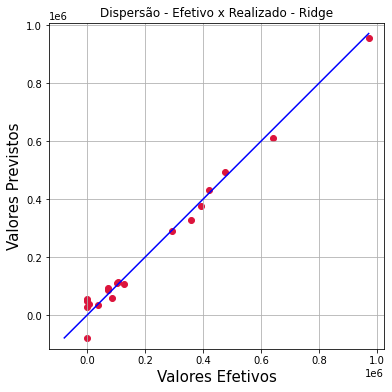

In [1884]:
# RIDGE REGRESSION
from sklearn.linear_model import Ridge

modelo_rd = Ridge()

# Treinar
modelo_rd.fit(x_train, y_train)

# Predicao
previsao_rd = modelo_rd.predict(x_test)

print(f'Ridge: {metrics.r2_score(y_test, previsao_rd)}')

print('********** Parametros funcao linear ********************************')
print('intercept_ -> {} '.format(modelo_rd.intercept_))
print('coef_      -> {} '.format(modelo_rd.coef_))

#print(type(previsao_rd))
#print(previsao_rd)

# Copiando dataframe para outro
df_result=y_test.copy()

# adicionar coluna ao dataframe df_result
df_result['VL_PREVISTO_ALGORITMO']=0

j = 0
for index,v in y_test['VL_VENDA_TOT'].iteritems():
    #print('y_test index-> {} , y_test VL_VENDA_TOT -> {} , predicao {} '.format(index,v, previsao_regressaolinear[j]))
    if index in df_result.index:
        df_result['VL_PREVISTO_ALGORITMO'][index]=previsao_rd[j]
    j+=1

# adicionar coluna ao dataframe df_result subtraindo VL_VENDA_TOT, VL_PREVISTO_ALGORITMO     
df_result['VL_RESIDUO']=df_result['VL_PREVISTO_ALGORITMO']-df_result['VL_VENDA_TOT']
    
print(df_result.sort_index())    
df_result.sort_index().to_excel(r'c:\windows\temp\residuos_RIDGE_seed_' + str(SEED) + '_' + sIT_CODIGO + '.xlsx', index = True)

# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_result['VL_PREVISTO_ALGORITMO']))
true_value = tuple(list(df_result['VL_VENDA_TOT']))


plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Dispersão - Efetivo x Realizado - Ridge')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()


LassoLars: 0.985943797361104
********** Parametros funcao linear ********************************
intercept_ -> [-154165.96848425] 
coef_      -> [ 7.94023406e+03 -3.89851698e+02  3.29905011e+00  2.79400109e+03] 
    VL_VENDA_TOT  VL_PREVISTO_ALGORITMO  VL_RESIDUO
4       72655.44                  95182    22526.56
7        1869.57                  55726    53856.43
10      71366.61                  86350    14983.39
11       1704.35                  51100    49395.65
15       6097.74                  39332    33234.26
17     102735.85                 112378     9642.15
19     108890.40                 115582     6691.60
20      85420.22                  60209   -25211.22
28       1186.70                  28416    27229.30
31      37680.68                  35068    -2612.68
34     394171.58                 374831   -19340.58
36     358162.34                 329821   -28341.34
50     476770.57                 494601    17830.43
55     294453.82                 288198    -6255.82
58     

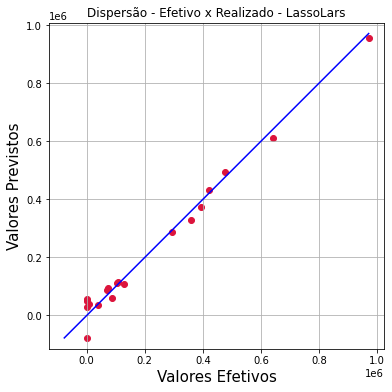

In [1885]:
# LASSO regression 
from sklearn.linear_model import LassoLars
#from sklearn.pipeline import make_pipeline

#modelo_lasso = LassoLars(normalize=True)
modelo_lasso = LassoLars()

# Treinar
modelo_lasso.fit(x_train, y_train)

# Predicao
previsao_lasso = modelo_lasso.predict(x_test)

print(f'LassoLars: {metrics.r2_score(y_test, previsao_lasso)}')

print('********** Parametros funcao linear ********************************')
print('intercept_ -> {} '.format(modelo_lasso.intercept_))
print('coef_      -> {} '.format(modelo_lasso.coef_))


#print(type(previsao_lasso))
#print(previsao_lasso)

# Copiando dataframe para outro
df_result=y_test.copy()

# adicionar coluna ao dataframe df_result
df_result['VL_PREVISTO_ALGORITMO']=0

j = 0
for index,v in y_test['VL_VENDA_TOT'].iteritems():
    #print('y_test index-> {} , y_test VL_VENDA_TOT -> {} , predicao {} '.format(index,v, previsao_regressaolinear[j]))
    if index in df_result.index:
        df_result['VL_PREVISTO_ALGORITMO'][index]=previsao_lasso[j]
    j+=1

# adicionar coluna ao dataframe df_result subtraindo VL_VENDA_TOT, VL_PREVISTO_ALGORITMO     
df_result['VL_RESIDUO']=df_result['VL_PREVISTO_ALGORITMO']-df_result['VL_VENDA_TOT']
    
print(df_result.sort_index())    
df_result.sort_index().to_excel(r'c:\windows\temp\residuos_LASSO_seed_' + str(SEED) + '_' + sIT_CODIGO + '.xlsx', index = True)

# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_result['VL_PREVISTO_ALGORITMO']))
true_value = tuple(list(df_result['VL_VENDA_TOT']))


plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Dispersão - Efetivo x Realizado - LassoLars')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()

RandomForestRegressor: 0.9620527554470717
********** Parametros funcao linear ********************************
    VL_VENDA_TOT  VL_PREVISTO_ALGORITMO  VL_RESIDUO
4       72655.44                  62977    -9678.44
7        1869.57                   1973      103.43
10      71366.61                  70272    -1094.61
11       1704.35                   2425      720.65
15       6097.74                   5764     -333.74
17     102735.85                  85054   -17681.85
19     108890.40                  88293   -20597.40
20      85420.22                 107342    21921.78
28       1186.70                   2059      872.30
31      37680.68                  34406    -3274.68
34     394171.58                 413119    18947.42
36     358162.34                 372081    13918.66
50     476770.57                 572520    95749.43
55     294453.82                 378728    84274.18
58     641882.85                 631578   -10304.85
59     127111.11                 152634    25522.89
65   

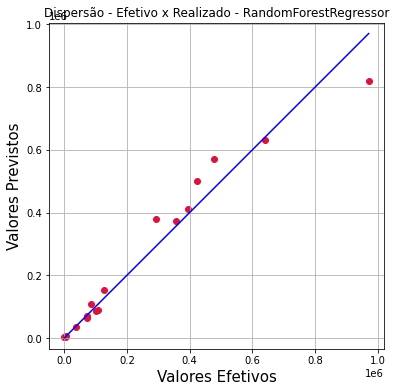

In [1886]:
# RADOM FOREST  -----------------------------------------------------------------------------------------------------------
# Instanciar
modelo_arvoredecisao = RandomForestRegressor()

# Treinar
modelo_arvoredecisao.fit(x_train, y_train)

# Predicao
previsao_arvoredecisao = modelo_arvoredecisao.predict(x_test)

# Vamos usar o R² -> diz o % que o nosso modelo consegue explicar o que acontece
# verificar acuracia do modelo
print(f'RandomForestRegressor: {metrics.r2_score(y_test, previsao_arvoredecisao)}')

print('********** Parametros funcao linear ********************************')
# RandomForest does not work with coefficients but rather be ensembling a lot of decisionTrees, which work by 
# sequentially splitting the data until some criteria are met.
#print('intercept_ -> {} '.format(modelo_arvoredecisao.intercept_))
#print('coef_      -> {} '.format(modelo_arvoredecisao.coef_))


#print(type(previsao_arvoredecisao))
#print(previsao_arvoredecisao)

# Copiando dataframe para outro
df_result=y_test.copy()

# adicionar coluna ao dataframe df_result
df_result['VL_PREVISTO_ALGORITMO']=0

j = 0
for index,v in y_test['VL_VENDA_TOT'].iteritems():
    #print('y_test index-> {} , y_test VL_VENDA_TOT -> {} , predicao {} '.format(index,v, previsao_regressaolinear[j]))
    if index in df_result.index:
        df_result['VL_PREVISTO_ALGORITMO'][index]=previsao_arvoredecisao[j]
    j+=1

# adicionar coluna ao dataframe df_result subtraindo VL_VENDA_TOT, VL_PREVISTO_ALGORITMO     
df_result['VL_RESIDUO']=df_result['VL_PREVISTO_ALGORITMO']-df_result['VL_VENDA_TOT']
    
print(df_result.sort_index())    
df_result.sort_index().to_excel(r'c:\windows\temp\residuos_RF_seed_' + str(SEED) + '_' + sIT_CODIGO + '.xlsx', index = True)

# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_result['VL_PREVISTO_ALGORITMO']))
true_value = tuple(list(df_result['VL_VENDA_TOT']))


plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Dispersão - Efetivo x Realizado - RandomForestRegressor')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()


REGRESSAO POLINOMIAL: 0.9746695425939309
********** Parametros funcao linear ********************************
intercept_ -> 21809.687830589217 
coef_      -> [0.00000000e+00 4.82519294e+02 6.31057546e-02] 
    VL_VENDA_TOT  VL_PREVISTO_ALGORITMO  VL_RESIDUO
4       72655.44                  46093   -26562.44
7        1869.57                  22292    20422.43
10      71366.61                  50988   -20378.61
11       1704.35                  22292    20587.65
15       6097.74                  24223    18125.26
17     102735.85                  68218   -34517.85
19     108890.40                  74657   -34233.40
20      85420.22                 111718    26297.78
28       1186.70                  22292    21105.30
31      37680.68                  43650     5969.32
34     394171.58                 301873   -92298.58
36     358162.34                 298570   -59592.34
50     476770.57                 544998    68227.43
55     294453.82                 345229    50775.18
58     641882.

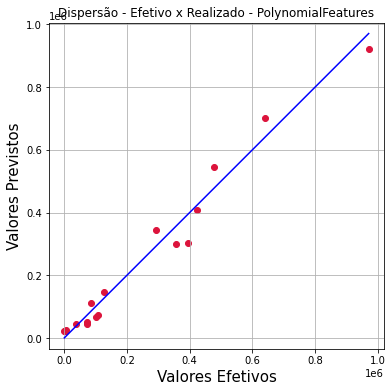

In [1887]:
# REGRESSAO POLINOMIAL COM SKLEARN
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Pré Processamento
pre_process = PolynomialFeatures(degree=2)
# Caso queira o grau 3 basta alterar o parametro degree

# variavel independente
x = x_test[['QUANTIDADE']]

# variavel dependente
y = y_test.VL_VENDA_TOT

x_poly = pre_process.fit_transform(x)

# Criação do modelo
modelo_sk = LinearRegression()

modelo_sk.fit(x_poly, y)

previsao_regressaopolinomial = modelo_sk.predict(x_poly)

# Vamos usar o R² -> diz o % que o nosso modelo consegue explicar o que acontece
# verificar acuracia do modelo
print(f'REGRESSAO POLINOMIAL: {metrics.r2_score(y_test, previsao_regressaopolinomial)}')

print('********** Parametros funcao linear ********************************')
print('intercept_ -> {} '.format(modelo_sk.intercept_))
print('coef_      -> {} '.format(modelo_sk.coef_))


# Copiando dataframe para outro
df_result=y_test.copy()

# adicionar coluna ao dataframe df_result
df_result['VL_PREVISTO_ALGORITMO']=0

j = 0
for index,v in y_test['VL_VENDA_TOT'].iteritems():
    #print('y_test index-> {} , y_test VL_VENDA_TOT -> {} , predicao {} '.format(index,v, previsao_regressaolinear[j]))
    if index in df_result.index:
        df_result['VL_PREVISTO_ALGORITMO'][index]=previsao_regressaopolinomial[j]
    j+=1

# adicionar coluna ao dataframe df_result subtraindo VL_VENDA_TOT, VL_PREVISTO_ALGORITMO     
df_result['VL_RESIDUO']=df_result['VL_PREVISTO_ALGORITMO']-df_result['VL_VENDA_TOT']
    
print(df_result.sort_index())    
df_result.sort_index().to_excel(r'c:\windows\temp\residuos_POLINOMIAL_seed_' + str(SEED) + '_' + sIT_CODIGO + '.xlsx', index = True)

# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_result['VL_PREVISTO_ALGORITMO']))
true_value = tuple(list(df_result['VL_VENDA_TOT']))

plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Dispersão - Efetivo x Realizado - PolynomialFeatures')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()


In [1888]:
# REGRESSAO VETORIAL DE SUPORTE - SVR -----------------------------------------------------------------------------------------

Regressao Vetorial de Suporte - SVR: 0.9913870280036559
********** Parametros svr ********************************
intercept_ -> [-3297.08075388] 
coef_      -> [[   0.37089298 -284.16947437    2.96582083   54.53815384]] 
    VL_VENDA_TOT  VL_PREVISTO_ALGORITMO  VL_RESIDUO
4       72655.44                  52623   -20032.44
7        1869.57                   1896       26.43
10      71366.61                  67093    -4273.61
11       1704.35                   1761       56.65
15       6097.74                   5015    -1082.74
17     102735.85                  74754   -27981.85
19     108890.40                  77159   -31731.40
20      85420.22                 127714    42293.78
28       1186.70                   1184       -2.70
31      37680.68                  41104     3423.32
34     394171.58                 371233   -22938.58
36     358162.34                 330440   -27722.34
50     476770.57                 532379    55608.43
55     294453.82                 331967    37513.1

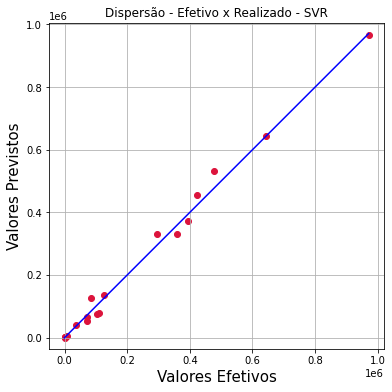

In [1889]:
from sklearn.svm import SVR
svr = SVR(kernel='linear')
svr.fit(x_test, y_test)
#print('SVR score {:.6f}'.format(svr.score(x_test, y_test)))
previsao_svr = svr.predict(x_test)

# Vamos usar o R² -> diz o % que o nosso modelo consegue explicar o que acontece
# verificar acuracia do modelo
print(f'Regressao Vetorial de Suporte - SVR: {metrics.r2_score(y_test, previsao_svr)}')

print('********** Parametros svr ********************************')
print('intercept_ -> {} '.format(svr.intercept_))
print('coef_      -> {} '.format(svr.coef_))



# Copiando dataframe para outro
df_result=y_test.copy()

# adicionar coluna ao dataframe df_result
df_result['VL_PREVISTO_ALGORITMO']=0

j = 0
for index,v in y_test['VL_VENDA_TOT'].iteritems():
    #print('y_test index-> {} , y_test VL_VENDA_TOT -> {} , predicao {} '.format(index,v, previsao_regressaolinear[j]))
    if index in df_result.index:
        df_result['VL_PREVISTO_ALGORITMO'][index]=previsao_svr[j]
    j+=1

# adicionar coluna ao dataframe df_result subtraindo VL_VENDA_TOT, VL_PREVISTO_ALGORITMO     
df_result['VL_RESIDUO']=df_result['VL_PREVISTO_ALGORITMO']-df_result['VL_VENDA_TOT']
    
print(df_result.sort_index())    
df_result.sort_index().to_excel(r'c:\windows\temp\residuos_SVR_seed_' + str(SEED) + '_' + sIT_CODIGO + '.xlsx', index = True)

# Convert Pandas Dataframe to a Tuple
predicted_value = tuple(list(df_result['VL_PREVISTO_ALGORITMO']))
true_value = tuple(list(df_result['VL_VENDA_TOT']))


plt.figure(figsize=(6,6))
plt.scatter(true_value, predicted_value, c='crimson')
#plt.yscale('log')
#plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')

plt.title('Dispersão - Efetivo x Realizado - SVR')
plt.xlabel('Valores Efetivos', fontsize=15)
plt.ylabel('Valores Previstos', fontsize=15)
plt.axis('equal')
plt.grid(True)
plt.show()


In [1890]:
print(previsao_svr)

[  1896.91015886  67093.64679934  74754.23945009 134657.26055947
  -1223.63332177  77159.55046834 331967.99135628   5015.33553112
  52623.96165639 532379.09703535 454681.32171419 371233.02276409
 127714.74123896 330440.40067971   1761.95001948 966459.99143565
  41104.66187771 645276.83591298   1184.43681268]


In [1891]:
# Visualização Gráfica das Previsões
tab_aux = pd.DataFrame()
tab_aux["y_test"] = y_test
tab_aux["Linear Regression"] = previsao_regressaolinear
tab_aux["RandomForest Regressor"] = previsao_arvoredecisao
#tab_aux["Polynomial Regression"] = previsao_regressaopolinomial
tab_aux["Support Vector Regression - SVR"] = previsao_svr
tab_aux["Lasso Regression"] = previsao_lasso
tab_aux["Ridge Regression"] = previsao_rd
tab_aux["ElasticNet Regression"] = previsao_el
tab_aux["Simple Mean"] = previsao_media2

print('tab_aux  -------------------------------------------------------------')
print(tab_aux)
tab_aux.sort_index().to_excel(r'c:\windows\temp\comparativo_final_seed_' + str(SEED) + '_' + sIT_CODIGO + '.xlsx', index = True)

tab_aux  -------------------------------------------------------------
       y_test  Linear Regression  RandomForest Regressor  Support Vector Regression - SVR  Lasso Regression  Ridge Regression  ElasticNet Regression  Simple Mean
7     1869.57       55667.726862               1973.7883                      1896.910159      55726.247768      55318.866317           54390.301409          655
10   71366.61       86359.691863              70272.7519                     67093.646799      86350.536715      86614.766835           87024.582688        39359
17  102735.85      112366.204738              85054.0856                     74754.239450     112378.250288     111780.795598          110605.215177        62319
59  127111.11      107860.867963             152634.7931                    134657.260559     107853.814973     107837.707066          108033.103856       163999
74     433.36      -77201.436214               4302.0892                     -1223.633322     -77344.545393     -77524.

In [1892]:
# R2 Score ###############################################################################################


#  (coefficient of determination) regression score function.
# Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.


print('R2 Score ----------------------------------------------------------------------------------------------')
print(f'LinearRegression               : {metrics.r2_score(y_test, previsao_regressaolinear):.7f}')
print(f'RandomForestRegressor          : {metrics.r2_score(y_test, previsao_arvoredecisao):.7f}')
#print(f'Regressao polinomial           : {metrics.r2_score(y_test, previsao_regressaopolinomial)}')
print(f'Support Vector Regression - SVR: {metrics.r2_score(y_test, previsao_svr):.7f}')
print(f'Lasso Regression               : {metrics.r2_score(y_test, previsao_lasso):.7f}')
print(f'Ridge Regression               : {metrics.r2_score(y_test, previsao_rd):.7f}')
print(f'ElasticNet Regression          : {metrics.r2_score(y_test, previsao_el):.7f}')
print(f'Simple Mean                    : {metrics.r2_score(y_test, previsao_media2):.7f}')


# Creates a dictionary to store Linear Models.
#  "PolynomialFeatures": metrics.r2_score(y_test, previsao_regressaopolinomial),

dic_models = {
  "LinearRegression": metrics.r2_score(y_test, previsao_regressaolinear),
  "RandomForestRegressor": metrics.r2_score(y_test, previsao_arvoredecisao),
  "Support Vector Regression": metrics.r2_score(y_test, previsao_svr),
  "Lasso Regression": metrics.r2_score(y_test, previsao_lasso),
  "Ridge Regression":metrics.r2_score(y_test, previsao_rd),
  "ElasticNet Regression n": metrics.r2_score(y_test, previsao_el),
  "Simple Mean": metrics.r2_score(y_test, previsao_media2)
}    

# Select the best model.
bestModel = max(dic_models, key=dic_models.get)    

print("The best model r2 is: {0} with value: {1}".format(bestModel, dic_models[bestModel]))



R2 Score ----------------------------------------------------------------------------------------------
LinearRegression               : 0.9859703
RandomForestRegressor          : 0.9620528
Support Vector Regression - SVR: 0.9913870
Lasso Regression               : 0.9859438
Ridge Regression               : 0.9859974
ElasticNet Regression          : 0.9862212
Simple Mean                    : 0.9403611
The best model r2 is: Support Vector Regression with value: 0.9913870280036559


In [1893]:
# Erro Quadrático Médio (MSE-Mean squared error) Score  ###############################################

# Erro Quadrático Médio (MSE-Mean squared error)
# Mean squared error regression loss. - Perda de regressão de erro quadrático médio.

print('Erro Quadrático Médio (MSE-Mean squared error) Score ----------------------------------------------------')
print(f'LinearRegression                : {metrics.mean_squared_error(y_test, previsao_regressaolinear, squared=True):.7f}')
print(f'RandomForestRegressor           : {metrics.mean_squared_error(y_test, previsao_arvoredecisao, squared=True):.7f}')
#print(f'Regressao polinomial            : {metrics.mean_squared_error(y_test, previsao_regressaopolinomial, squared=True)}')
print(f'Support Vector Regression - SVR : {metrics.mean_squared_error(y_test, previsao_svr, squared=True):.7f}')
print(f'Lasso Regression                : {metrics.mean_squared_error(y_test, previsao_lasso):.7f}')
print(f'Ridge Regression                : {metrics.mean_squared_error(y_test, previsao_rd):.7f}')
print(f'ElasticNet Regression           : {metrics.mean_squared_error(y_test, previsao_el):.7f}')
print(f'Simple Mean                     : {metrics.mean_squared_error(y_test, previsao_media2, squared=True):.7f}')


# Creates a dictionary to store Linear Models.
#   "PolynomialFeatures": metrics.mean_squared_error(y_test, previsao_regressaopolinomial),

dic_models = {
  "LinearRegression": metrics.mean_squared_error(y_test, previsao_regressaolinear),
  "RandomForestRegressor": metrics.mean_squared_error(y_test, previsao_arvoredecisao),
  "Support Vector Regression": metrics.mean_squared_error(y_test, previsao_svr),
  "Lasso Regression": metrics.mean_squared_error(y_test, previsao_lasso),
  "Ridge Regression":metrics.mean_squared_error(y_test, previsao_rd),
  "ElasticNet Regression n": metrics.mean_squared_error(y_test, previsao_el),
  "Simple Mean": metrics.mean_squared_error(y_test, previsao_media2)
}    

# Select the best model.
bestModel = min(dic_models, key=dic_models.get)    

print("The best model MSE is: {0} with value: {1}".format(bestModel, dic_models[bestModel]))


Erro Quadrático Médio (MSE-Mean squared error) Score ----------------------------------------------------
LinearRegression                : 938463187.7110736
RandomForestRegressor           : 2538337649.5342269
Support Vector Regression - SVR : 576132242.2820605
Lasso Regression                : 940236604.4793279
Ridge Regression                : 936651141.4280496
ElasticNet Regression           : 921683637.6157382
Simple Mean                     : 3989317498.2069845
The best model MSE is: Support Vector Regression with value: 576132242.2820605


In [1894]:
# Raiz quadrada do erro-médio (RMSE - Root-mean-square deviation) Score  ########################################


# Raiz quadrada do erro-médio (RMSE - Root-mean-square deviation)
# root Mean squared error regression loss - perda de regressão de erro quadrático médio
print('Raiz quadrada do erro-médio (RMSE - Root-mean-square deviation) Score ------------------------------------')

print(f'LinearRegression                : {metrics.mean_squared_error(y_test, previsao_regressaolinear, squared=False):.7f}')
print(f'RandomForestRegressor           : {metrics.mean_squared_error(y_test, previsao_arvoredecisao, squared=False):.7f}')
#print(f'Regressao polinomial            : {metrics.mean_squared_error(y_test, previsao_regressaopolinomial, squared=False)}')
print(f'Support Vector Regression - SVR : {metrics.mean_squared_error(y_test, previsao_svr, squared=False):.7f}')
print(f'Lasso Regression                : {metrics.mean_squared_error(y_test, previsao_lasso, squared=False):.7f}')
print(f'Ridge Regression                : {metrics.mean_squared_error(y_test, previsao_rd, squared=False):.7f}')
print(f'ElasticNet Regression           : {metrics.mean_squared_error(y_test, previsao_el, squared=False):.7f}')
print(f'Simple Mean                     : {metrics.mean_squared_error(y_test, previsao_media2, squared=False):.7f}')


# Creates a dictionary to store Linear Models.
#   "PolynomialFeatures": metrics.mean_squared_error(y_test, previsao_regressaopolinomial, squared=False),

dic_models = {
  "LinearRegression": metrics.mean_squared_error(y_test, previsao_regressaolinear, squared=False),
  "RandomForestRegressor": metrics.mean_squared_error(y_test, previsao_arvoredecisao, squared=False),
  "Support Vector Regression": metrics.mean_squared_error(y_test, previsao_svr, squared=False),
  "Lasso Regression": metrics.mean_squared_error(y_test, previsao_lasso, squared=False),
  "Ridge Regression":metrics.mean_squared_error(y_test, previsao_rd, squared=False),
  "ElasticNet Regression n": metrics.mean_squared_error(y_test, previsao_el, squared=False),
  "Simple Mean": metrics.mean_squared_error(y_test, previsao_media2, squared=False)
}    

# Select the best model.
bestModel = min(dic_models, key=dic_models.get)    

print("The best model RMSE is: {0} with value: {1}".format(bestModel, dic_models[bestModel]))



Raiz quadrada do erro-médio (RMSE - Root-mean-square deviation) Score ------------------------------------
LinearRegression                : 30634.3465364
RandomForestRegressor           : 50381.9178827
Support Vector Regression - SVR : 24002.7548894
Lasso Regression                : 30663.2777843
Ridge Regression                : 30604.7568431
ElasticNet Regression           : 30359.2430343
Simple Mean                     : 63161.0441507
The best model RMSE is: Support Vector Regression with value: 24002.7548894301


In [1895]:
# Erro absoluto médio (MAE - Mean Absolute Error) Score  ########################################
print('Erro absoluto médio (MAE - Mean Absolute Error) Score  ------------------------------------')

# mean_absolute_error

print(f'LinearRegression                : {metrics.mean_absolute_error(y_test, previsao_regressaolinear):.7f}')
print(f'RandomForestRegressor           : {metrics.mean_absolute_error(y_test, previsao_arvoredecisao):.7f}')
print(f'Support Vector Regression - SVR : {metrics.mean_absolute_error(y_test, previsao_svr):.7f}')
print(f'Lasso Regression                : {metrics.mean_absolute_error(y_test, previsao_lasso):.7f}')
print(f'Ridge Regression                : {metrics.mean_absolute_error(y_test, previsao_rd):.7f}')
print(f'ElasticNet Regression           : {metrics.mean_absolute_error(y_test, previsao_el):.7f}')
print(f'Simple Mean                     : {metrics.mean_absolute_error(y_test, previsao_media2):.7f}')


dic_models = {
  "LinearRegression": metrics.mean_absolute_error(y_test, previsao_regressaolinear),
  "RandomForestRegressor": metrics.mean_absolute_error(y_test, previsao_arvoredecisao),
  "Support Vector Regression": metrics.mean_absolute_error(y_test, previsao_svr),
  "Lasso Regression": metrics.mean_absolute_error(y_test, previsao_lasso),
  "Ridge Regression":metrics.mean_absolute_error(y_test, previsao_rd),
  "ElasticNet Regression n": metrics.mean_absolute_error(y_test, previsao_el),
  "Simple Mean": metrics.mean_absolute_error(y_test, previsao_media2)
}    

# Select the best model.
bestModel = min(dic_models, key=dic_models.get)    

print("The best model MAE is: {0} with value: {1}".format(bestModel, dic_models[bestModel]))




Erro absoluto médio (MAE - Mean Absolute Error) Score  ------------------------------------
LinearRegression                : 24717.0412610
RandomForestRegressor           : 29435.7393263
Support Vector Regression - SVR : 17069.1403999
Lasso Regression                : 24730.2135198
Ridge Regression                : 24566.8337645
ElasticNet Regression           : 24152.6743028
Simple Mean                     : 42367.8868421
The best model MAE is: Support Vector Regression with value: 17069.14039987519


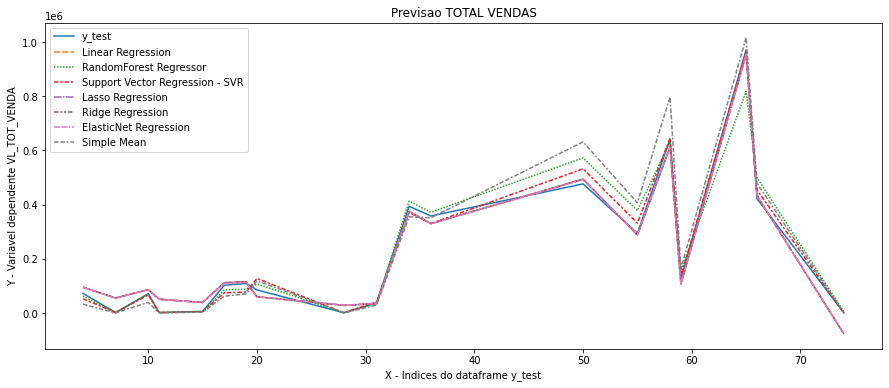

In [1896]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=tab_aux)
plt.title("Previsao TOTAL VENDAS")
plt.ylabel('Y - Variavel dependente VL_TOT_VENDA')
plt.xlabel('X - Indices do dataframe y_test')
plt.show()